In [1]:
# Clustering of timeseries data
import pandas as pd
import numpy as np

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler
from VisualizationFunctions import plot_by_factor, AnalyzeClusters
%matplotlib inline

In [2]:
print('Reading in the data...')
agg = pd.read_csv('sku_labels.csv')
df = pd.read_csv('extracted_features.csv')
sales = pd.read_csv('aggregate_products.csv')
df.dropna(axis=1, inplace=True)

scale = MinMaxScaler()
skus = df['id']
df.set_index('id', inplace=True)
X = scale.fit_transform(df)
names = df.columns

Reading in the data...


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
print('Running Dimentionality Reduction...')
dimred = TSNE(2)
tsnes = dimred.fit_transform(X)

#Merge tsne coordinates onto original df with sku_keys
plot_df = pd.DataFrame(tsnes).join(df.reset_index())

#Merge above tsne and features table to sku_key and categories
plot_df['sku_key'] = plot_df['id'].astype(int)
agg['sku_key'] = agg['sku_key'].astype(int)
plot_df = plot_df.merge(agg, how='left', on='sku_key')

colors=['b', 'r', 'g', 'y', 'm', 'orange', 'gold', 'skyblue']

Running Dimentionality Reduction...


In [4]:
plot_df.head()

,0,1,id,sales__abs_energy,sales__absolute_sum_of_changes,"sales__agg_autocorrelation__f_agg_""mean""","sales__agg_autocorrelation__f_agg_""median""","sales__agg_autocorrelation__f_agg_""var""","sales__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","sales__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""",...,sales__value_count__value_1,sales__value_count__value_inf,sales__value_count__value_nan,sales__variance,sales__variance_larger_than_standard_deviation,sku_key,sku_department,sku_subdepartment,sku_category,sku_subcategory
0,30.847179,2.024862,28,455.0,228.0,0.009909,-0.001607,0.001339,0.188732,0.359772,...,25.0,0.0,0.0,0.621100,0.0,28,TY,06,063,20G
1,16.731766,9.392357,34,186.0,226.0,-0.004615,-0.017574,0.001181,1.335614,-0.138257,...,78.0,0.0,0.0,0.236220,0.0,34,TY,4,11,35A
2,-24.556885,-48.090900,100,6946.0,1549.0,0.009112,0.010989,0.001624,7.239437,-0.195348,...,157.0,0.0,0.0,5.145510,1.0,100,BH,02,38,C09
3,11.979848,52.417988,152,78.0,85.0,-0.002430,-0.012023,0.001742,0.699379,-0.093300,...,16.0,0.0,0.0,0.109897,0.0,152,BH,02,139,00L
4,0.203780,-35.636032,182,4038.0,1163.0,-0.005931,-0.003367,0.001556,3.848592,0.159739,...,135.0,0.0,0.0,4.060313,1.0,182,TY,8,33,16K


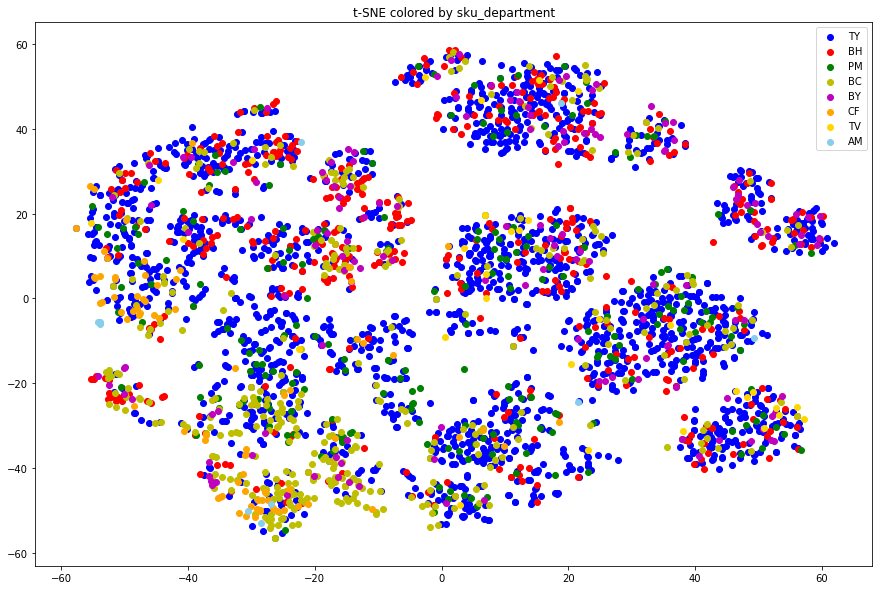

In [5]:
plot_by_factor(plot_df, 'sku_department', colors, showplot=True)

In [6]:
sales_df = sales.groupby('sku_key').sum().reset_index()[['sku_key', 'sales']].merge(plot_df, on='sku_key')[['sku_key', 'sales', 0,1]]
sales_df['class'] = [25 if x <= 50 else 75 if x <= 100 else 175 if x <= 250 \
                     else 375 if x <= 500 \
                     else 775 if x <=1000 else 2000 for x in sales_df['sales']]

In [7]:
sales_df['class'].value_counts()

25      797
175     785
75      592
375     479
775     310
2000    230
Name: class, dtype: int64

In [8]:
sales_df['sales_log'] = np.log10(sales_df['sales'])

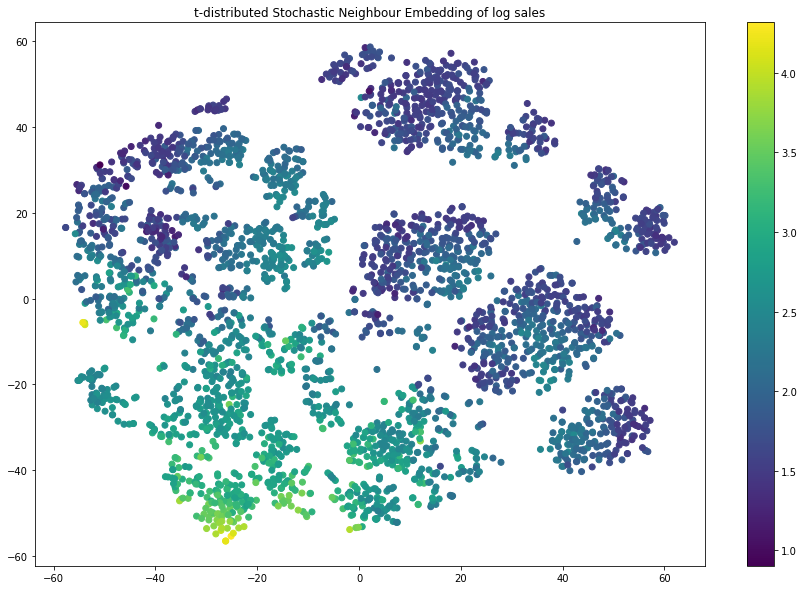

In [9]:
f, ax = plt.subplots(figsize=(15,10))
sc = ax.scatter(sales_df[0], sales_df[1], c=sales_df['sales_log'], cmap='viridis')
plt.colorbar(sc)
ax.set_title('t-distributed Stochastic Neighbour Embedding of log sales')
plt.show()

In [10]:
colors = ['darkblue', 'tomato', 'orchid', 'darkorange', 'lime', 'gold', 'dodgerblue', 'pink',
          'grey', 'darkgreen', 'y', 'slateblue', 'r', 'brown']
run_cont = ['sales', 'selling_price', 'avg_discount']
run_cats = ['sku_department', 'sku_subdepartment', 'sku_category', 'sku_subcategory']

product_sales = pd.read_csv('aggregate_products.csv')
som_clus = pd.read_csv('som_clusters.csv')
som_clus.columns = ['sku_key', 'cluster']

analyze_som = AnalyzeClusters()
df_dict = analyze_som.make_dataset(product_sales, som_clus)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


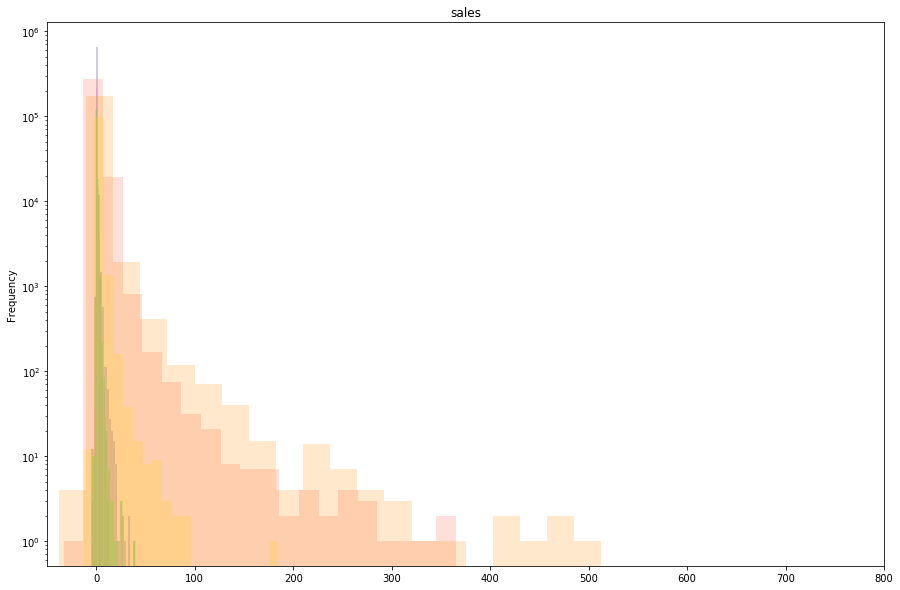

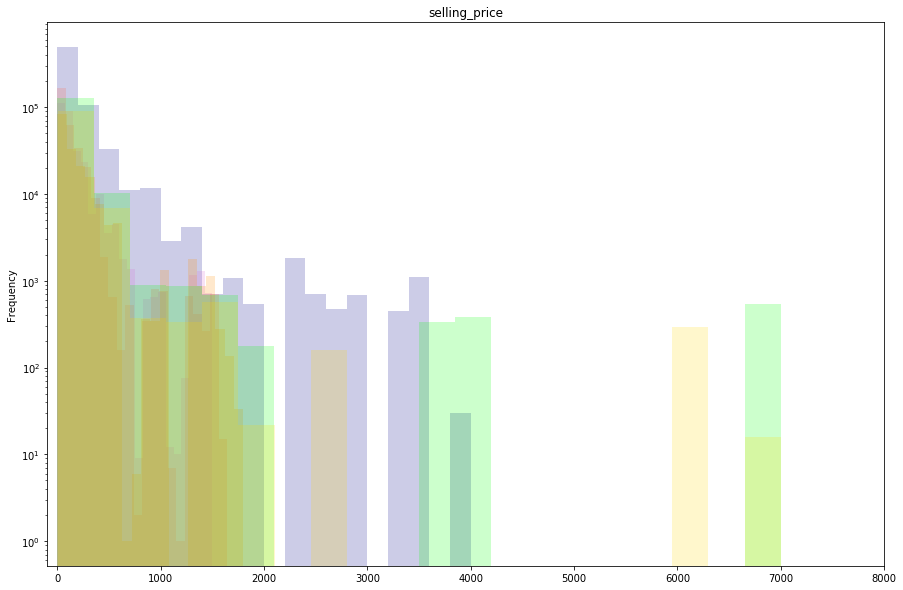

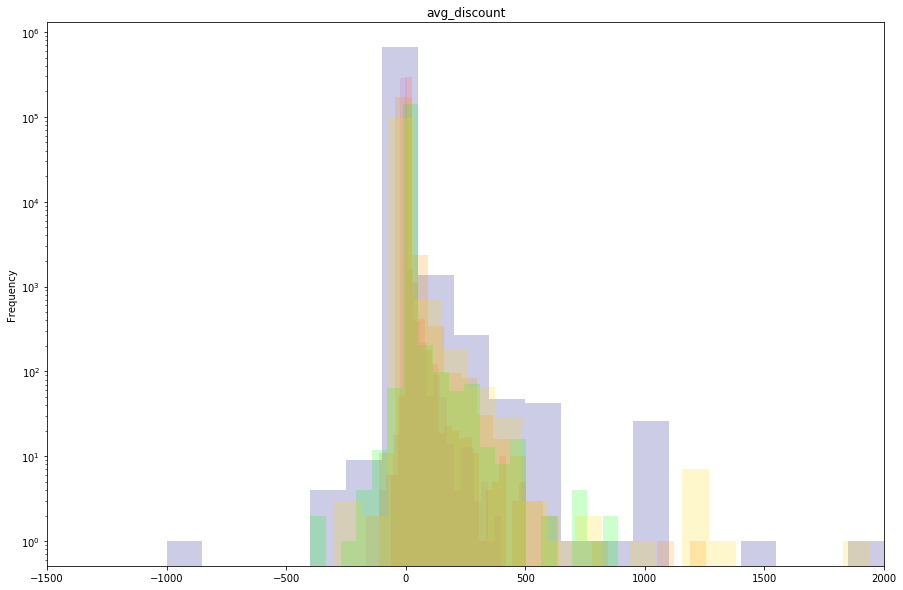

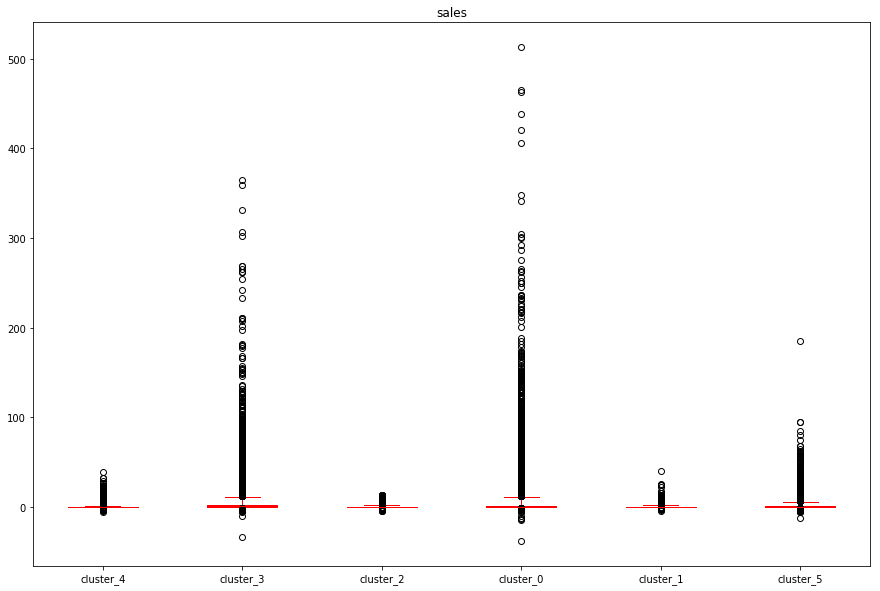

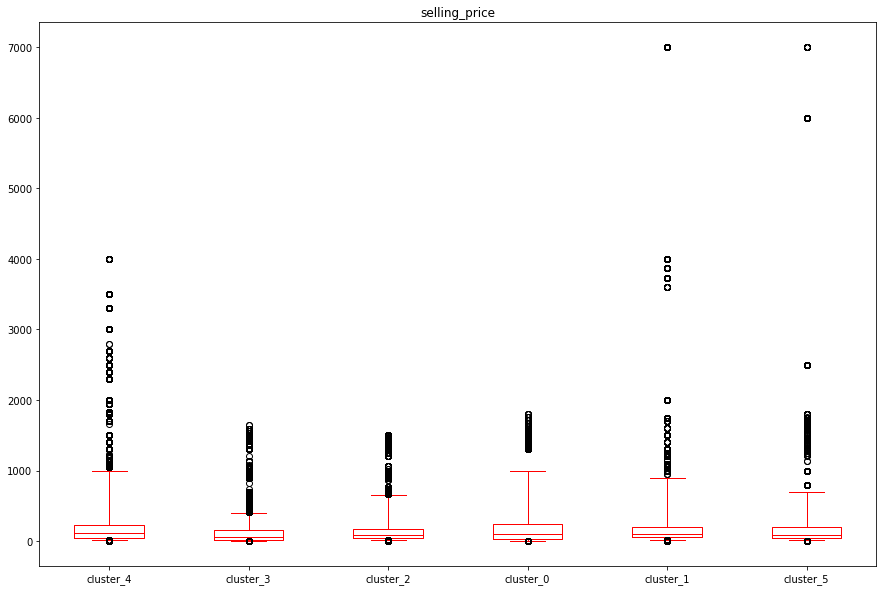

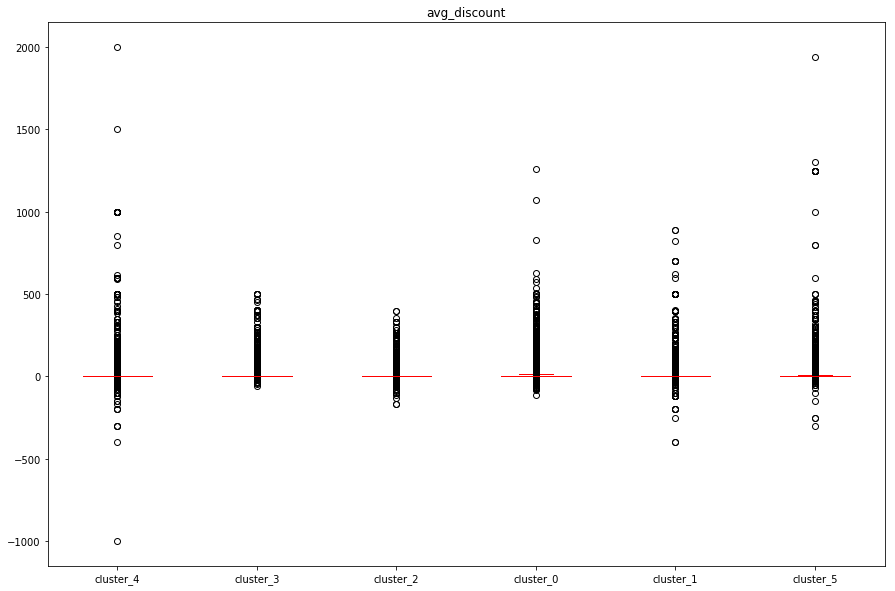

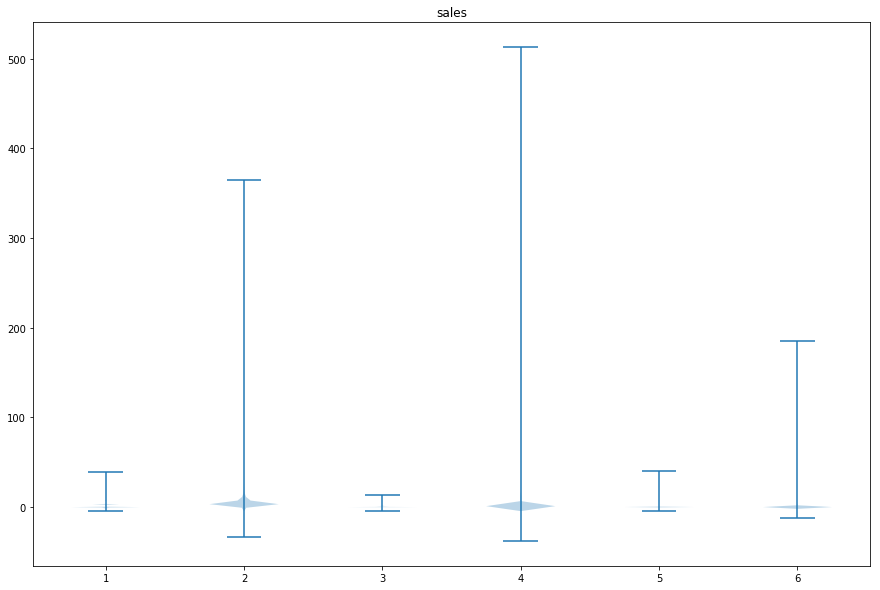

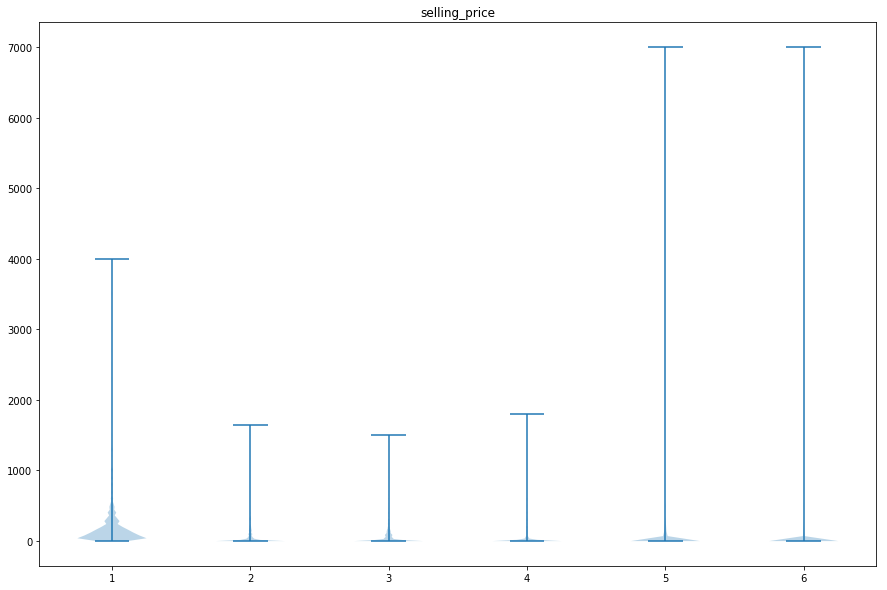

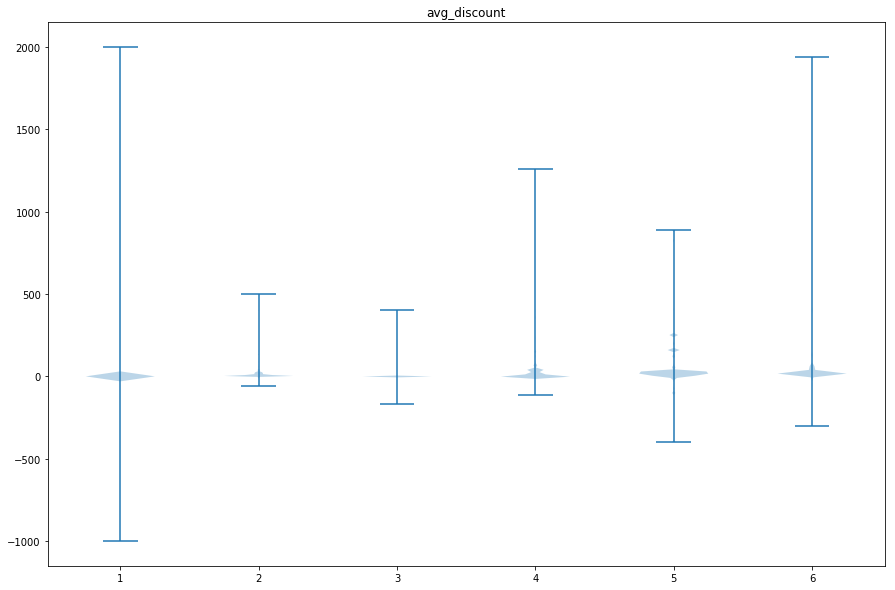



 sku_department


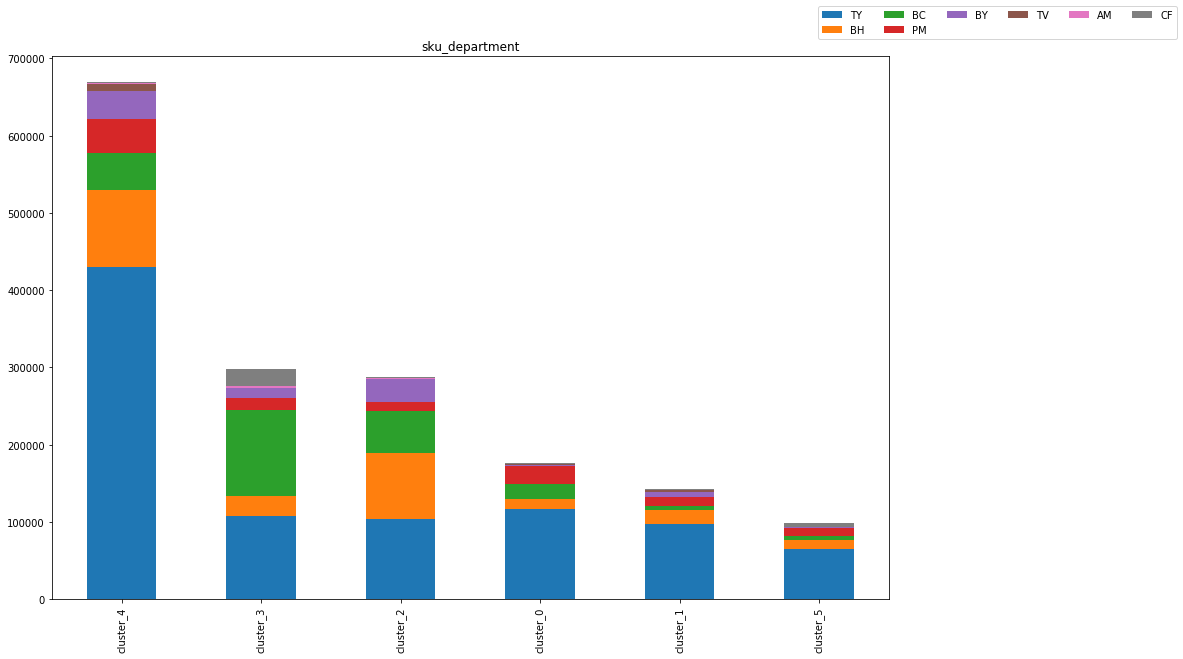



 sku_subdepartment


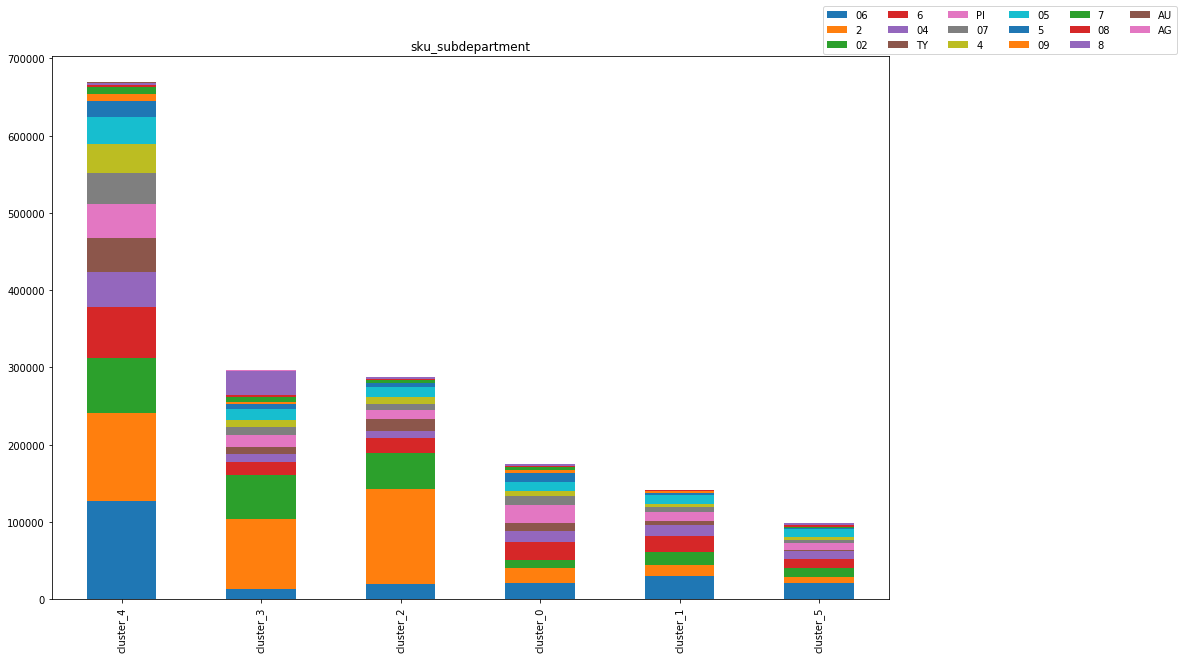



 sku_category


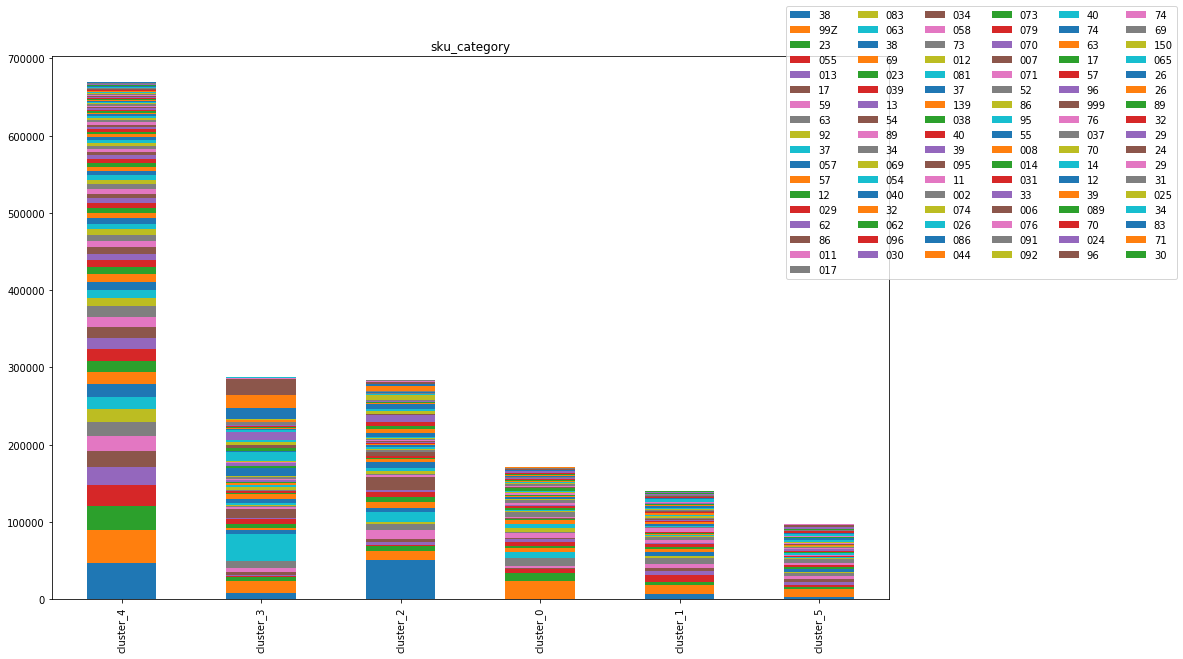



 sku_subcategory


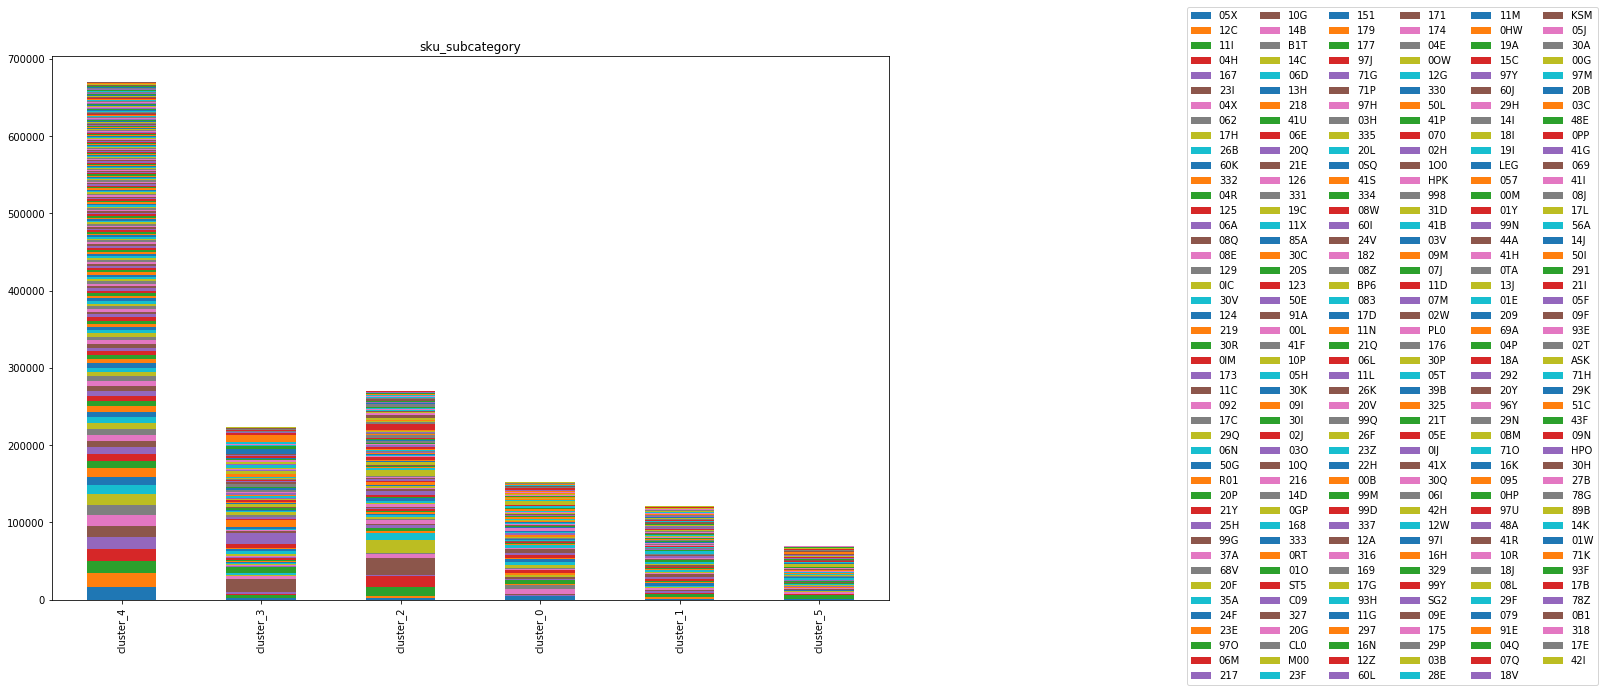

In [11]:
analyze_som.plot_cluster_continuous(df_dict, run_cont, colors, True)
analyze_som.plot_cluster_continuous_box(df_dict, run_cont, True)
analyze_som.plot_cluster_continuous_violin(df_dict, run_cont, True)
analyze_som.plot_cluster_categorical(df_dict, run_cats, True)

In [11]:
analyze_som.test_continuous_feat(df_dict, run_cont)

sales
                sum_sq         df             F  PR(>F)
cluster   9.306368e+05        5.0  17924.944399     0.0
Residual  1.738394e+07  1674156.0           NaN     NaN
 Multiple Comparison of Means - Tukey HSD,FWER=0.05
  group1    group2  meandiff  lower   upper  reject
---------------------------------------------------
cluster_0 cluster_1 -1.3519  -1.3846 -1.3191  True 
cluster_0 cluster_2 -1.1937  -1.2214 -1.1659  True 
cluster_0 cluster_3  0.4584   0.4308  0.486   True 
cluster_0 cluster_4 -1.4178  -1.4424 -1.3932  True 
cluster_0 cluster_5 -0.5868  -0.6233 -0.5503  True 
cluster_1 cluster_2  0.1582   0.1284  0.188   True 
cluster_1 cluster_3  1.8103   1.7807  1.8398  True 
cluster_1 cluster_4  -0.066  -0.0928 -0.0391  True 
cluster_1 cluster_5  0.7651   0.727   0.8031  True 
cluster_2 cluster_3  1.6521   1.6281  1.676   True 
cluster_2 cluster_4 -0.2241  -0.2446 -0.2037  True 
cluster_2 cluster_5  0.6069   0.573   0.6407  True 
cluster_3 cluster_4 -1.8762  -1.8964  -1.856  

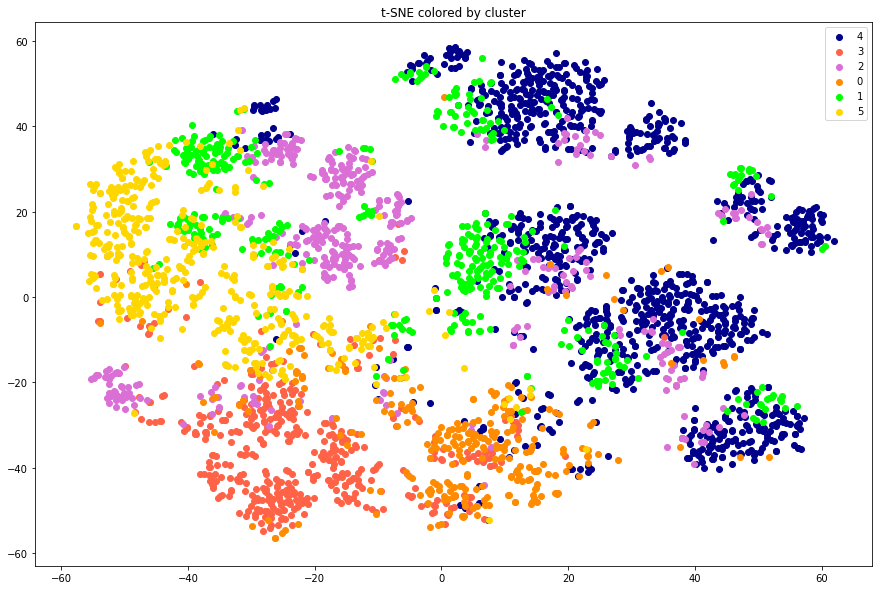

In [12]:
som_tsne = plot_df.merge(som_clus, left_on='id', right_on='sku_key')

plot_by_factor(som_tsne, 'cluster', colors, True)

In [13]:
som_sales_df = sales_df.merge(som_clus, on='sku_key')
som_sales_df.head()

,sku_key,sales,0,1,class,sales_log,cluster
0,28,119,30.847179,2.024862,175,2.075547,4
1,34,122,16.731766,9.392357,175,2.086360,4
2,100,1530,-24.556885,-48.090900,2000,3.184691,3
3,152,44,11.979848,52.417988,25,1.643453,4
4,182,914,0.203780,-35.636032,775,2.960946,3


cluster 4
1113


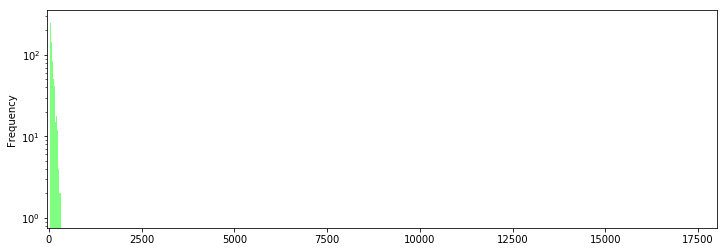

cluster 3
464


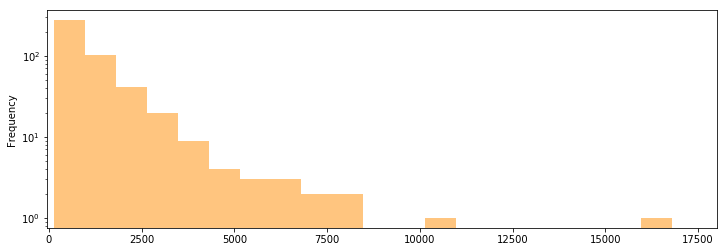

cluster 2
441


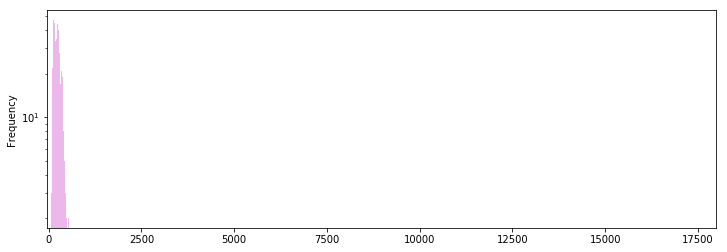

cluster 0
286


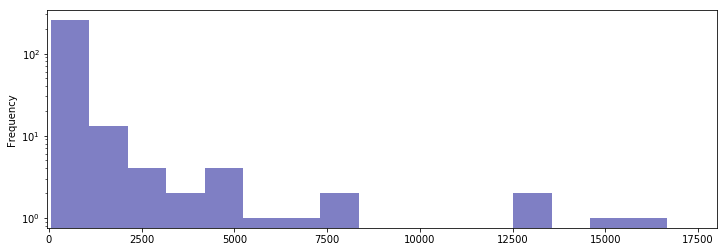

cluster 1
438


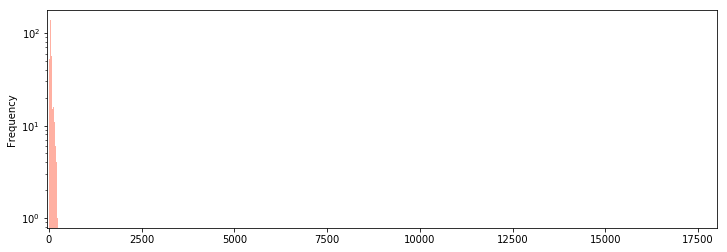

cluster 5
451


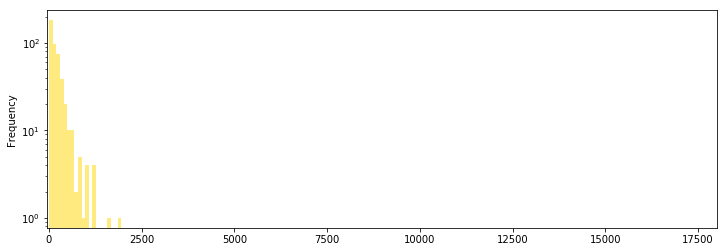

In [14]:
for i in som_sales_df['cluster'].unique():
    print('cluster {}'.format(i))
    print(len(som_sales_df[som_sales_df['cluster'] == i]['sales']))
    f, ax = plt.subplots(figsize=(12,4))
    som_sales_df[som_sales_df['cluster'] == i]['sales'].T.plot(kind='hist', color=colors[i], alpha=0.5, bins=20, ax=ax, logy=True)
    ax.set_xlim(-50, 18000)
    plt.show()

In [15]:
for a, i in enumerate(som_sales_df['cluster'].unique()):
    if a == 0:
        int_df = pd.DataFrame(som_sales_df[som_sales_df['cluster'] == i]['sales'])
        int_df.columns = [i]
    else:
        temp = pd.DataFrame(som_sales_df[som_sales_df['cluster'] == i]['sales'])
        temp.columns = [i]
        int_df = int_df.join(temp, how='outer')


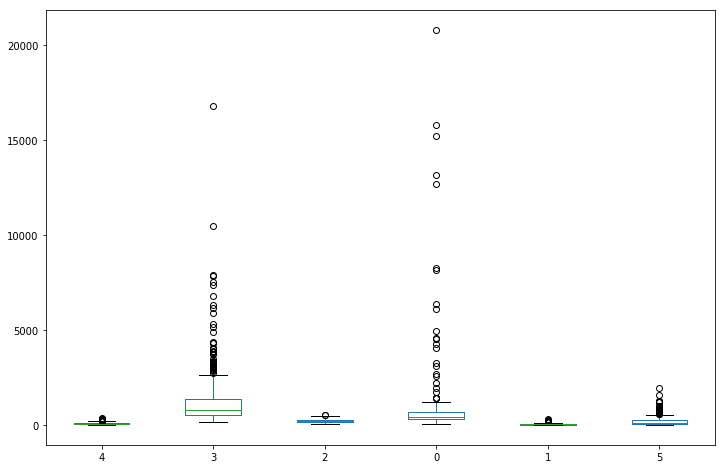

In [16]:
f, ax = plt.subplots(figsize=(12,8))
int_df.plot(kind='box', ax=ax)

In [17]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [18]:
int_df_unpiv = int_df.melt().dropna()
int_df_unpiv.columns = ['cluster', 'value']
int_df_unpiv.head()

,cluster,value
0,4,119.0
1,4,122.0
3,4,44.0
6,4,62.0
11,4,37.0


In [19]:
mod = ols('value ~ cluster',
                data=int_df_unpiv).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)


                sum_sq      df          F        PR(>F)
cluster   5.337753e+07     1.0  56.566962  7.019791e-14
Residual  3.011081e+09  3191.0        NaN           NaN


In [39]:
from statsmodels.stats.multicomp import MultiComparison

In [21]:
print(pairwise_tukeyhsd(int_df_unpiv['value'], int_df_unpiv['cluster']))

  Multiple Comparison of Means - Tukey HSD,FWER=0.05 
group1 group2  meandiff    lower      upper    reject
-----------------------------------------------------
  0      1    -890.9324  -1079.7785 -702.0863   True 
  0      2    -723.2793  -911.8715  -534.6872   True 
  0      3     334.8205   148.0762   521.5648   True 
  0      4    -876.5065  -1041.1851  -711.828   True 
  0      5    -743.3833  -931.1511  -555.6154   True 
  1      2     167.6531    0.0828    335.2233   True 
  1      3    1225.7529  1060.2651  1391.2407   True 
  1      4     14.4259   -125.6876   154.5394  False 
  1      5     147.5492   -19.0928   314.1911  False 
  2      3    1058.0998   892.9018  1223.2978   True 
  2      4    -153.2272  -292.9983   -13.4561   True 
  2      5     -20.1039  -186.4581   146.2502  False 
  3      4    -1211.327  -1348.5946 -1074.0594  True 
  3      5    -1078.2037  -1242.46  -913.9474   True 
  4      5     133.1233   -5.5336    271.7801  False 
----------------------------

## t-SNE

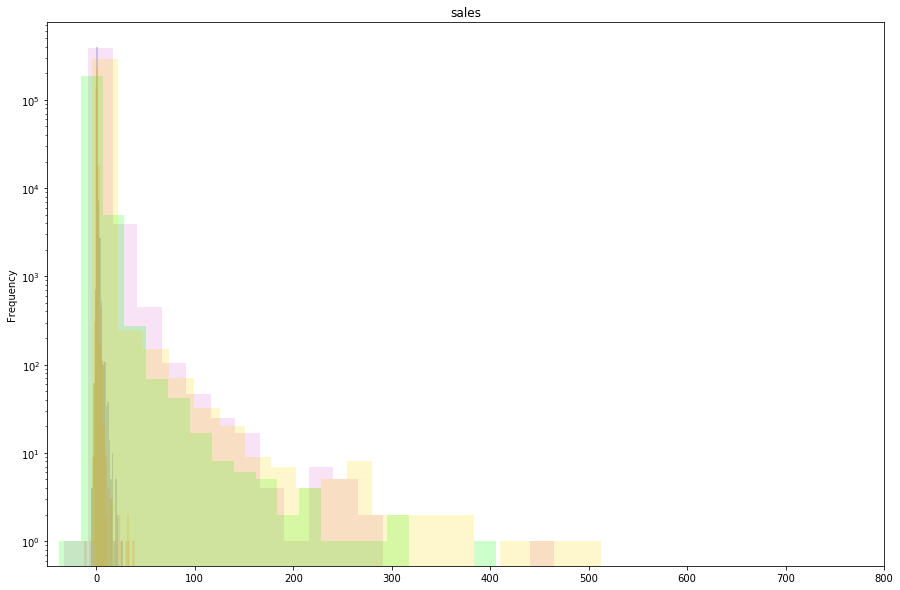

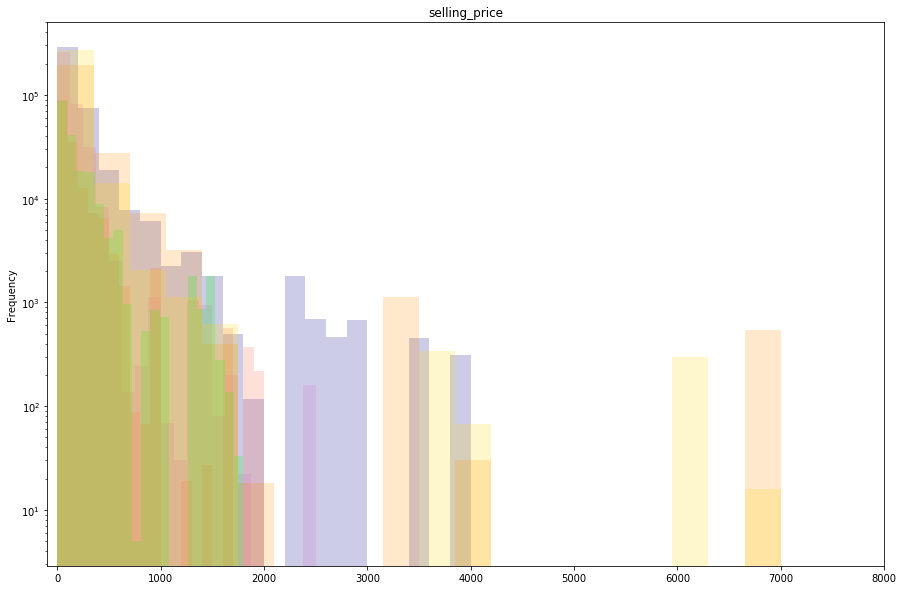

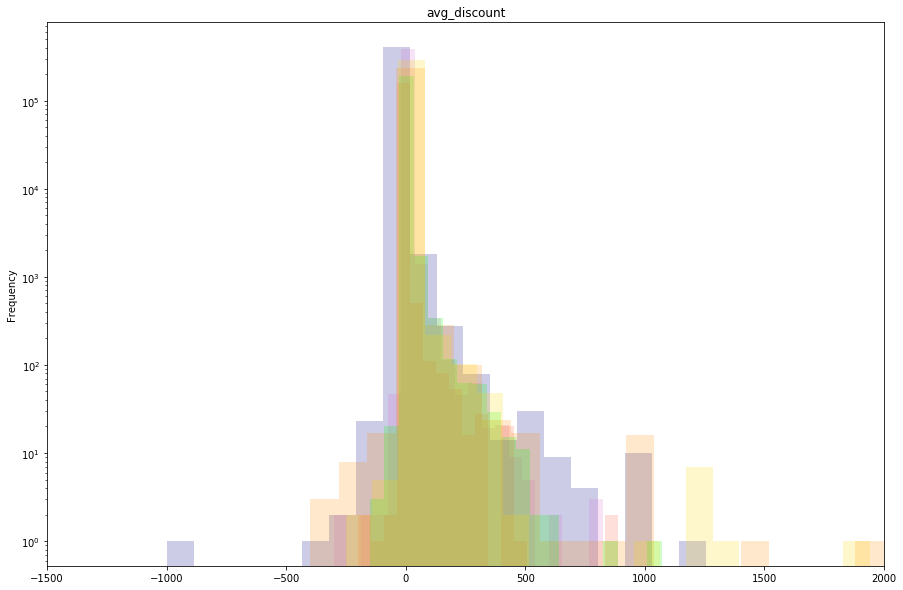

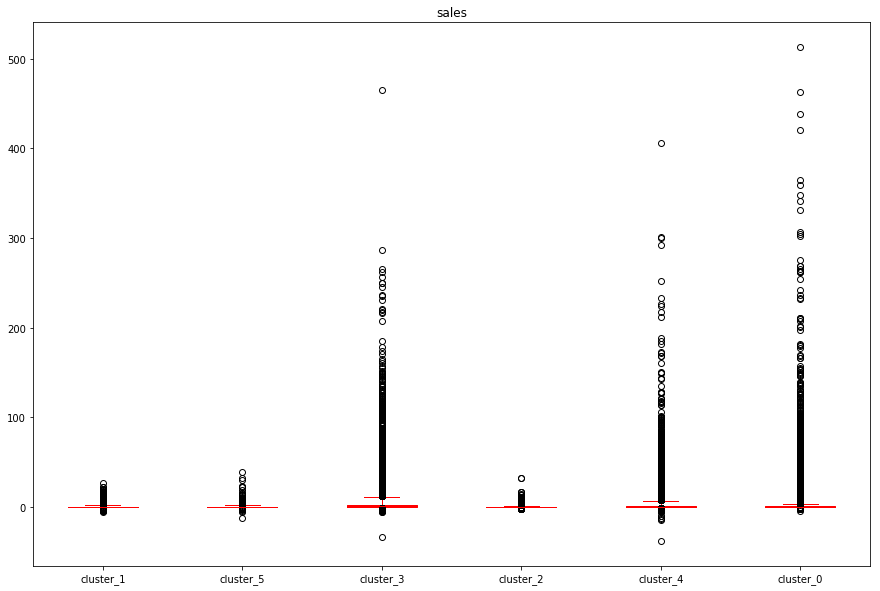

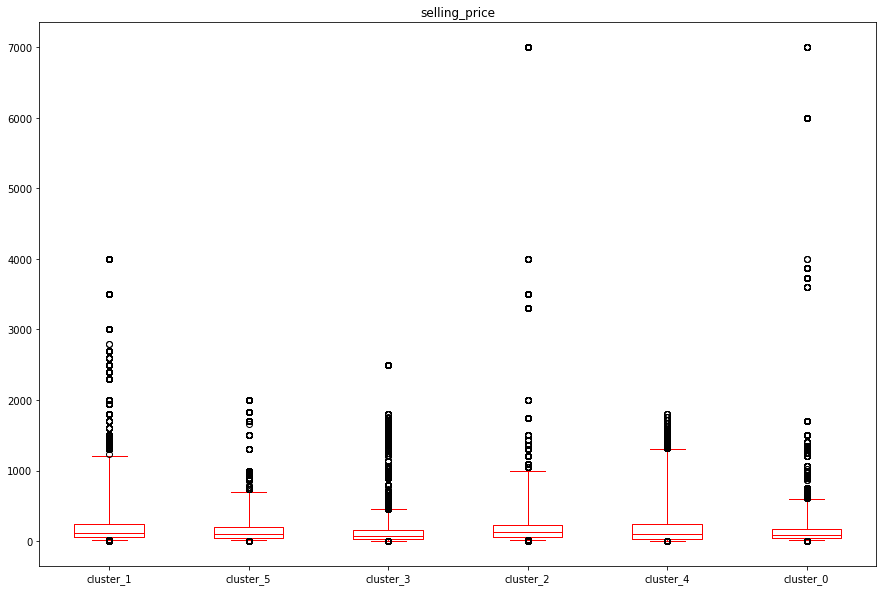

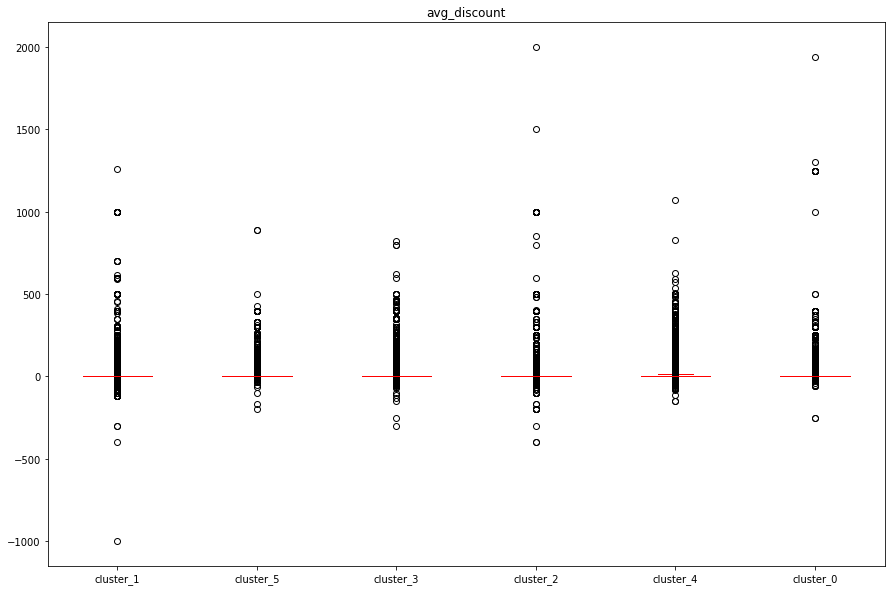

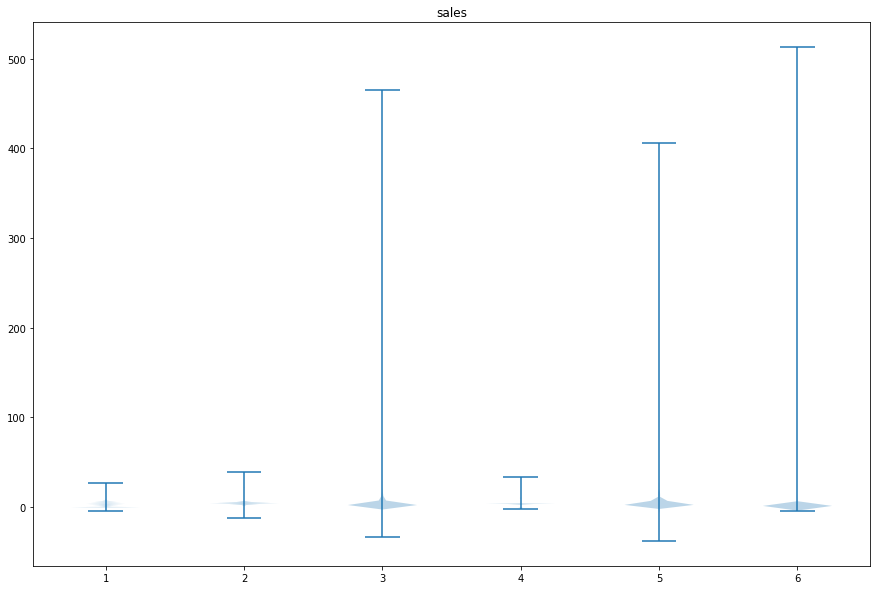

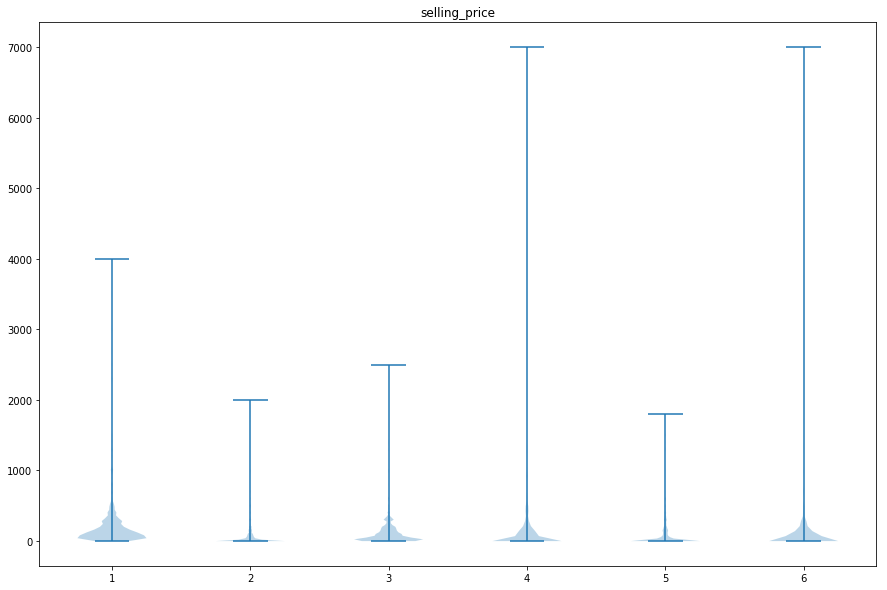

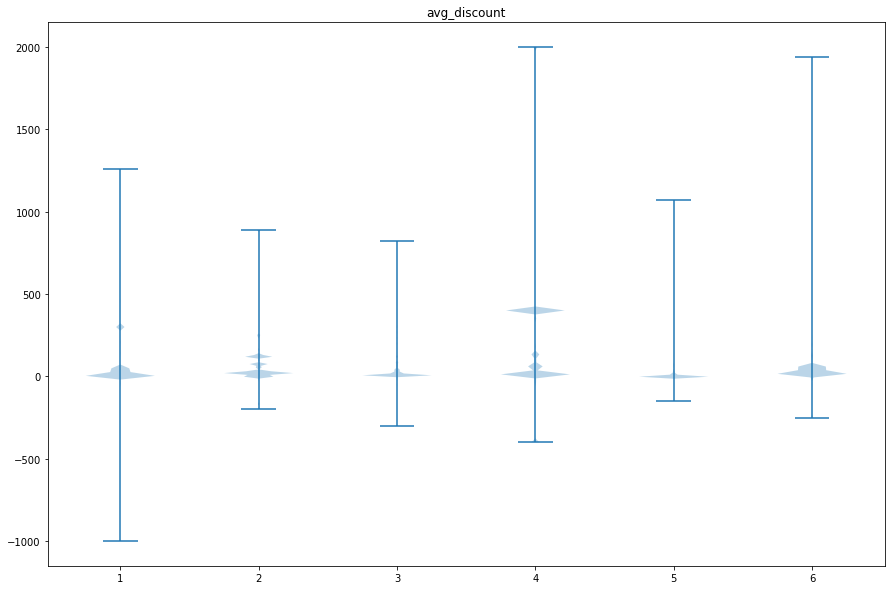



 sku_department


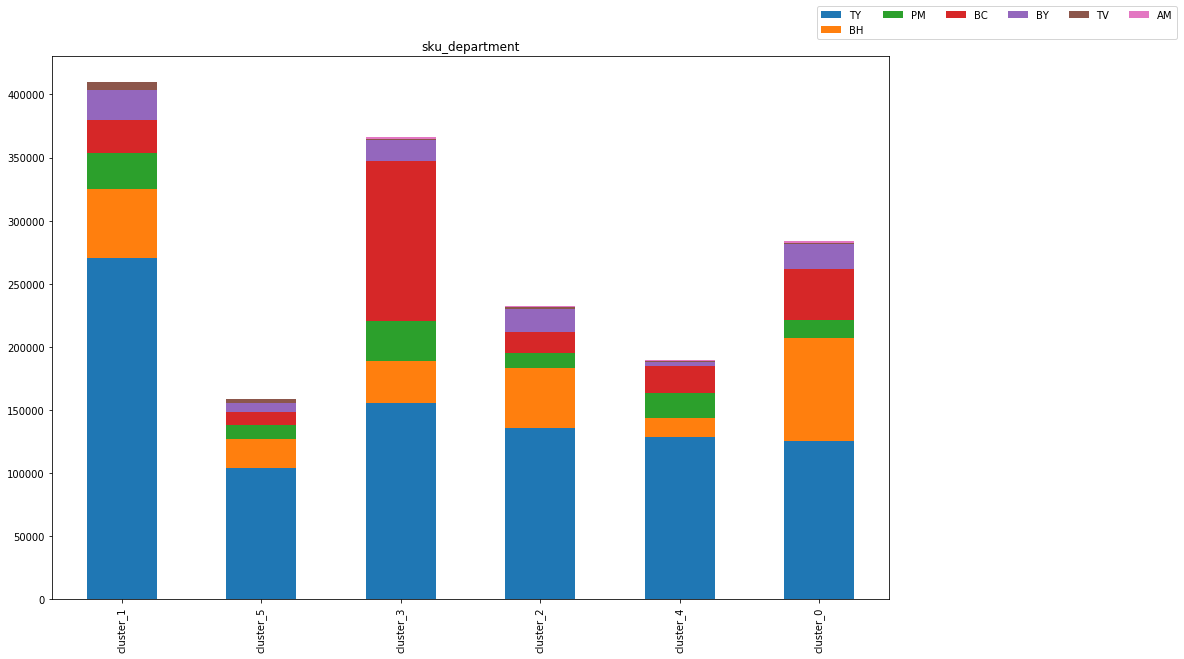



 sku_subdepartment


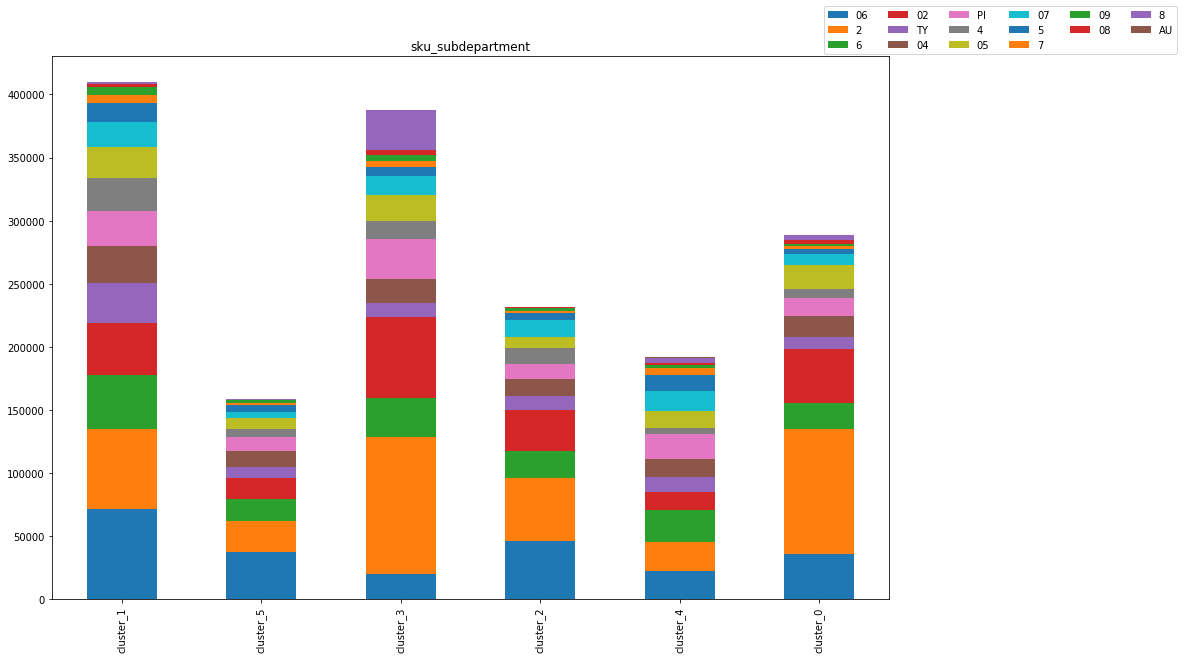



 sku_category


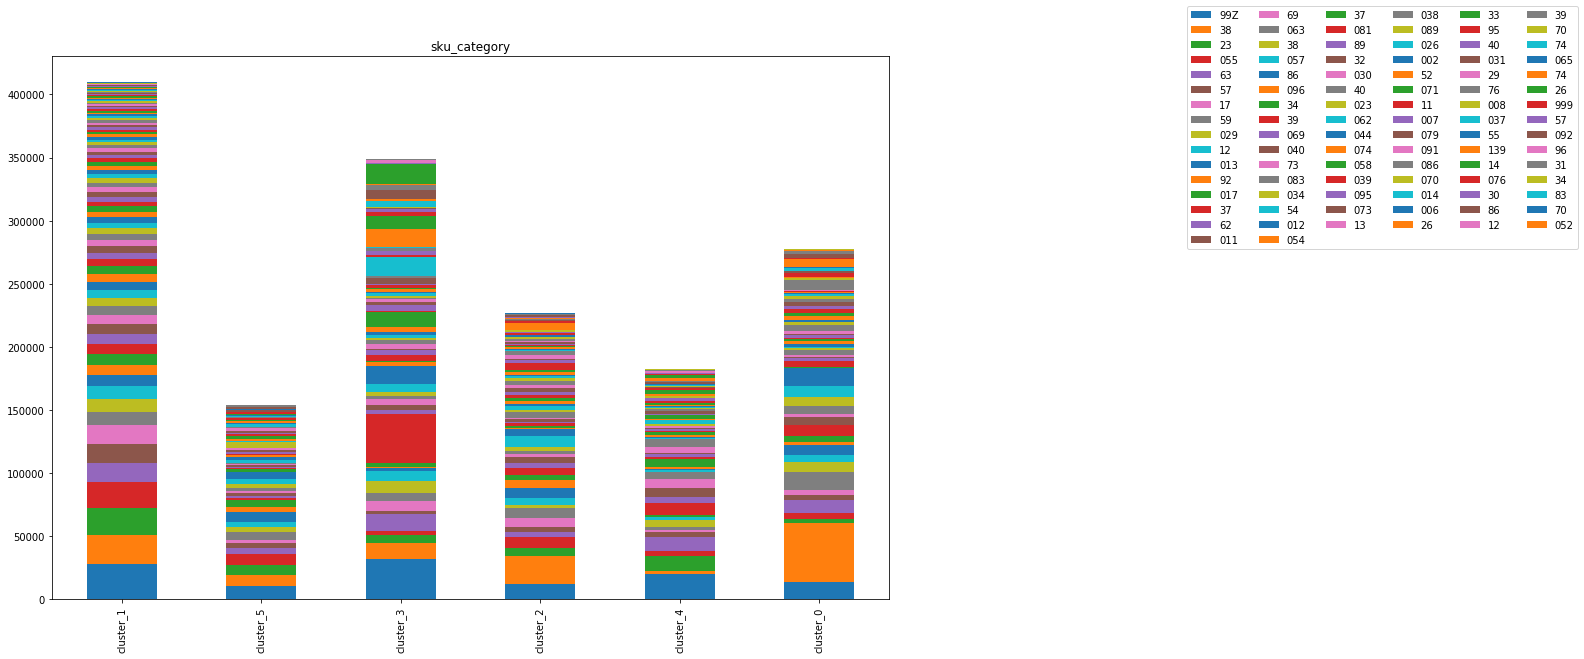



 sku_subcategory


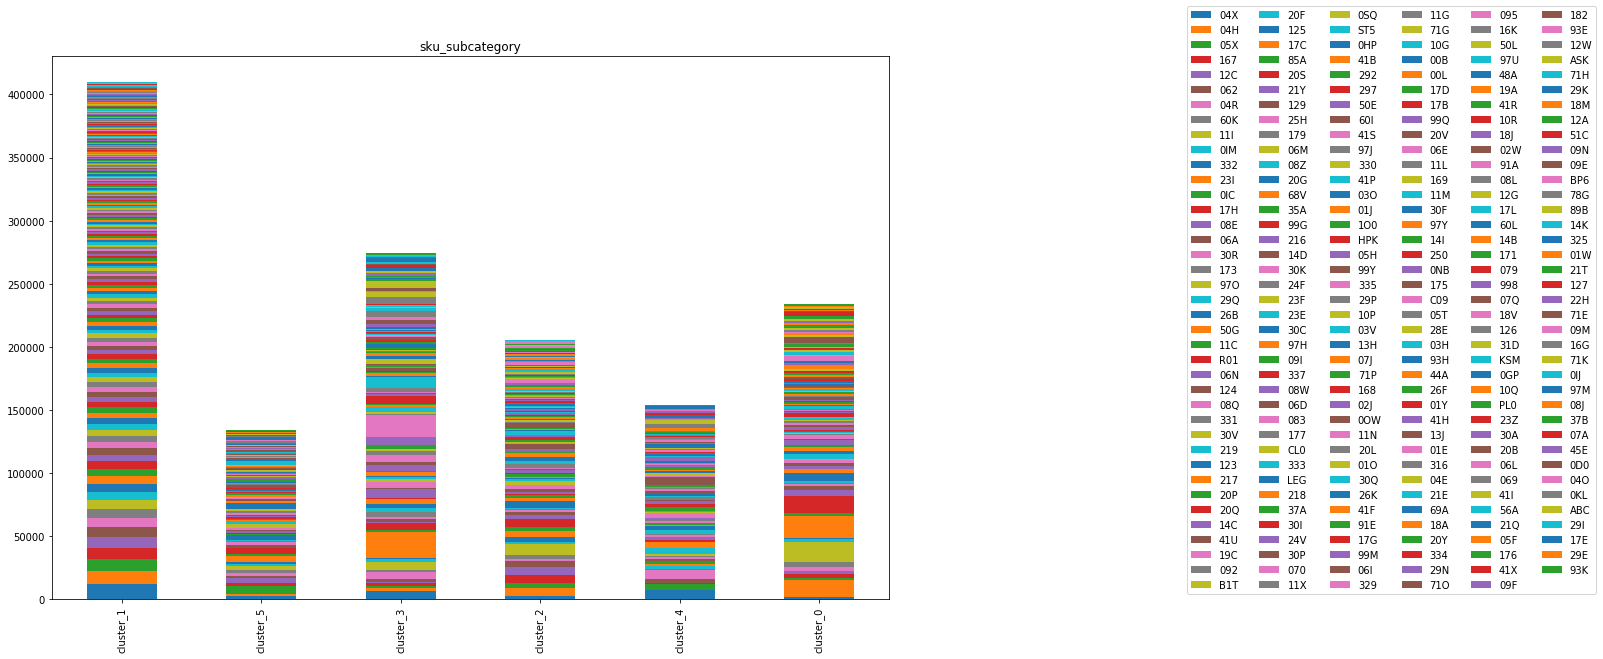

In [22]:
tsne_clus = pd.read_csv('tsne_clusters.csv')
tsne_clus.columns = ['sku_key', 'cluster']

analyze_tsne = AnalyzeClusters()
df_dict = analyze_tsne.make_dataset(product_sales, tsne_clus)

analyze_tsne.plot_cluster_continuous(df_dict, run_cont, colors, True)
analyze_tsne.plot_cluster_continuous_box(df_dict, run_cont, True)
analyze_tsne.plot_cluster_continuous_violin(df_dict, run_cont, True)
analyze_tsne.plot_cluster_categorical(df_dict, run_cats, True)

In [23]:
analyze_som.test_continuous_feat(df_dict, run_cont)

sales
                sum_sq         df             F  PR(>F)
cluster   7.477739e+05        5.0  14252.904281     0.0
Residual  1.756681e+07  1674156.0           NaN     NaN
 Multiple Comparison of Means - Tukey HSD,FWER=0.05
  group1    group2  meandiff  lower   upper  reject
---------------------------------------------------
cluster_0 cluster_1 -0.4328  -0.4552 -0.4104  True 
cluster_0 cluster_2 -0.4858  -0.5115 -0.4601  True 
cluster_0 cluster_3  1.2118   1.1892  1.2345  True 
cluster_0 cluster_4  0.4545   0.4274  0.4817  True 
cluster_0 cluster_5 -0.4209  -0.4497 -0.3921  True 
cluster_1 cluster_2  -0.053   -0.077 -0.0291  True 
cluster_1 cluster_3  1.6446   1.624   1.6653  True 
cluster_1 cluster_4  0.8873   0.8618  0.9128  True 
cluster_1 cluster_5  0.0119  -0.0154  0.0391 False 
cluster_2 cluster_3  1.6976   1.6735  1.7218  True 
cluster_2 cluster_4  0.9403   0.9119  0.9688  True 
cluster_2 cluster_5  0.0649   0.0348  0.0949  True 
cluster_3 cluster_4 -0.7573   -0.783 -0.7316  

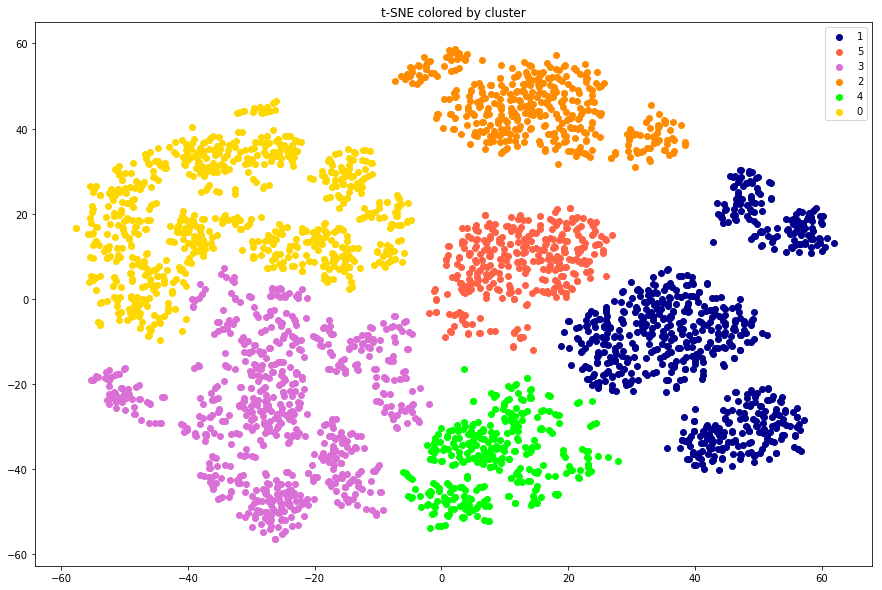

In [24]:
tsne_tsne = plot_df.merge(tsne_clus, left_on='id', right_on='sku_key')

plot_by_factor(tsne_tsne, 'cluster', colors, True)

In [25]:
tsne_sales_df = sales_df.merge(tsne_clus, on='sku_key')
tsne_sales_df.head()

,sku_key,sales,0,1,class,sales_log,cluster
0,28,119,30.847179,2.024862,175,2.075547,1
1,34,122,16.731766,9.392357,175,2.086360,5
2,100,1530,-24.556885,-48.090900,2000,3.184691,3
3,152,44,11.979848,52.417988,25,1.643453,2
4,182,914,0.203780,-35.636032,775,2.960946,4


cluster 1
697


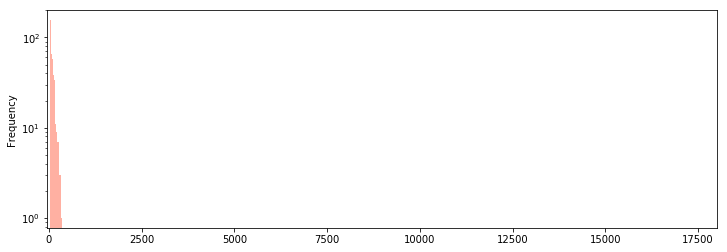

cluster 5
324


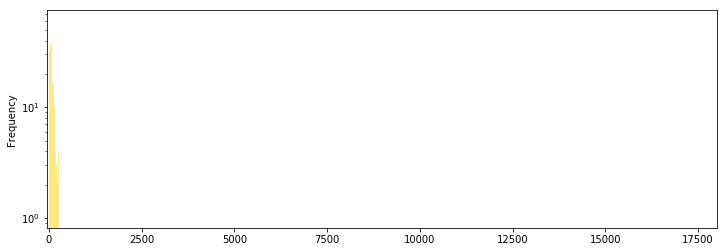

cluster 3
701


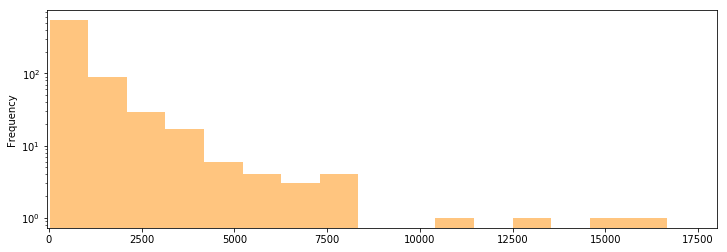

cluster 2
400


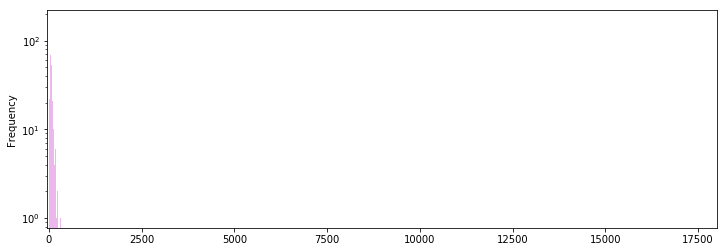

cluster 4
317


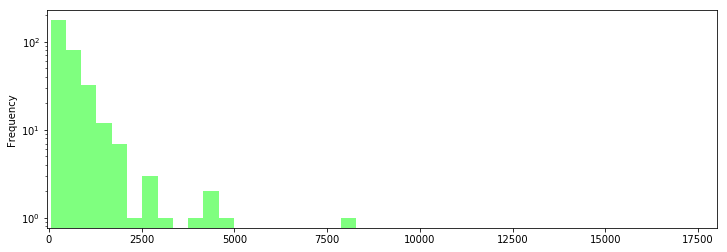

cluster 0
754


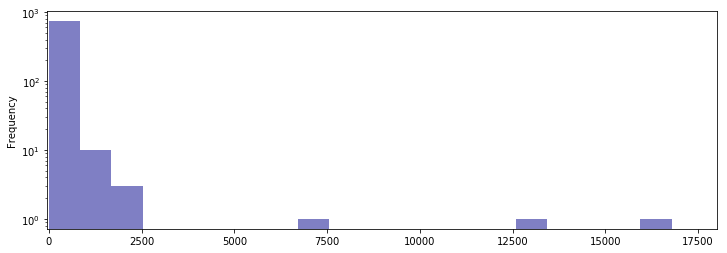

In [26]:
for i in tsne_sales_df['cluster'].unique():
    print('cluster {}'.format(i))
    print(len(tsne_sales_df[tsne_sales_df['cluster'] == i]['sales']))
    f, ax = plt.subplots(figsize=(12,4))
    tsne_sales_df[tsne_sales_df['cluster'] == i]['sales'].T.plot(kind='hist', color=colors[i], alpha=0.5, bins=20, ax=ax, logy=True)
    ax.set_xlim(-50, 18000)
    plt.show()

In [27]:
for a, i in enumerate(tsne_sales_df['cluster'].unique()):
    if a == 0:
        int_df = pd.DataFrame(tsne_sales_df[tsne_sales_df['cluster'] == i]['sales'])
        int_df.columns = [i]
    else:
        temp = pd.DataFrame(tsne_sales_df[tsne_sales_df['cluster'] == i]['sales'])
        temp.columns = [i]
        int_df = int_df.join(temp, how='outer')


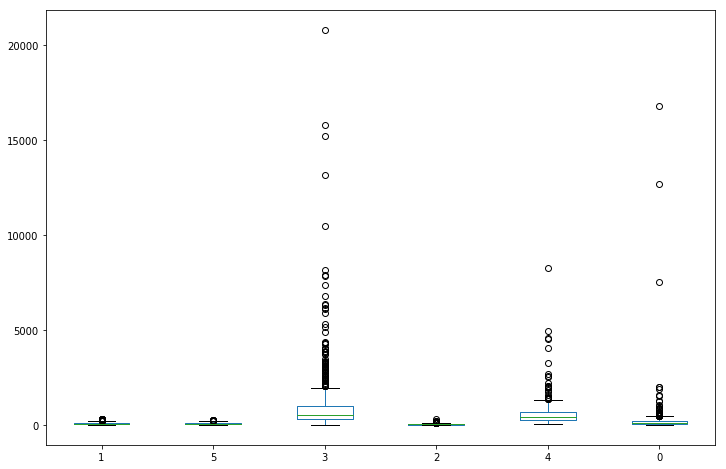

In [28]:
f, ax = plt.subplots(figsize=(12,8))
int_df.plot(kind='box', ax=ax)

In [29]:
int_df_unpiv = int_df.melt().dropna()
int_df_unpiv.columns = ['cluster', 'value']
int_df_unpiv.head()

,cluster,value
0,1,119.0
11,1,37.0
12,1,29.0
13,1,47.0
21,1,39.0


In [37]:
mod = ols('value ~ cluster',
                data=int_df_unpiv).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)


                sum_sq      df          F        PR(>F)
cluster   6.357657e+07     1.0  67.604399  2.874138e-16
Residual  3.000882e+09  3191.0        NaN           NaN


In [38]:
print(pairwise_tukeyhsd(int_df_unpiv['value'], int_df_unpiv['cluster']))

NameError: name 'pairwise_kruskal' is not defined

In [32]:
mod.

63576566.803697586

## Dynamic Time Warping

In [86]:
clusters_dtw = pd.read_csv('dtw_clusters_1.154.csv')
clusters_dtw.columns = ['sku_key', 'cluster']

In [87]:
len(clusters_dtw['cluster'].unique())

363

In [88]:
analyze_dtw = AnalyzeClusters()
df_dict = analyze_dtw.make_dataset(product_sales, clusters_dtw)

In [94]:
colors = 'r'*363

/home/andries/Project-Echo_edsa/clustering/VisualizationFunctions.py:8: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/ubuntu/anaconda

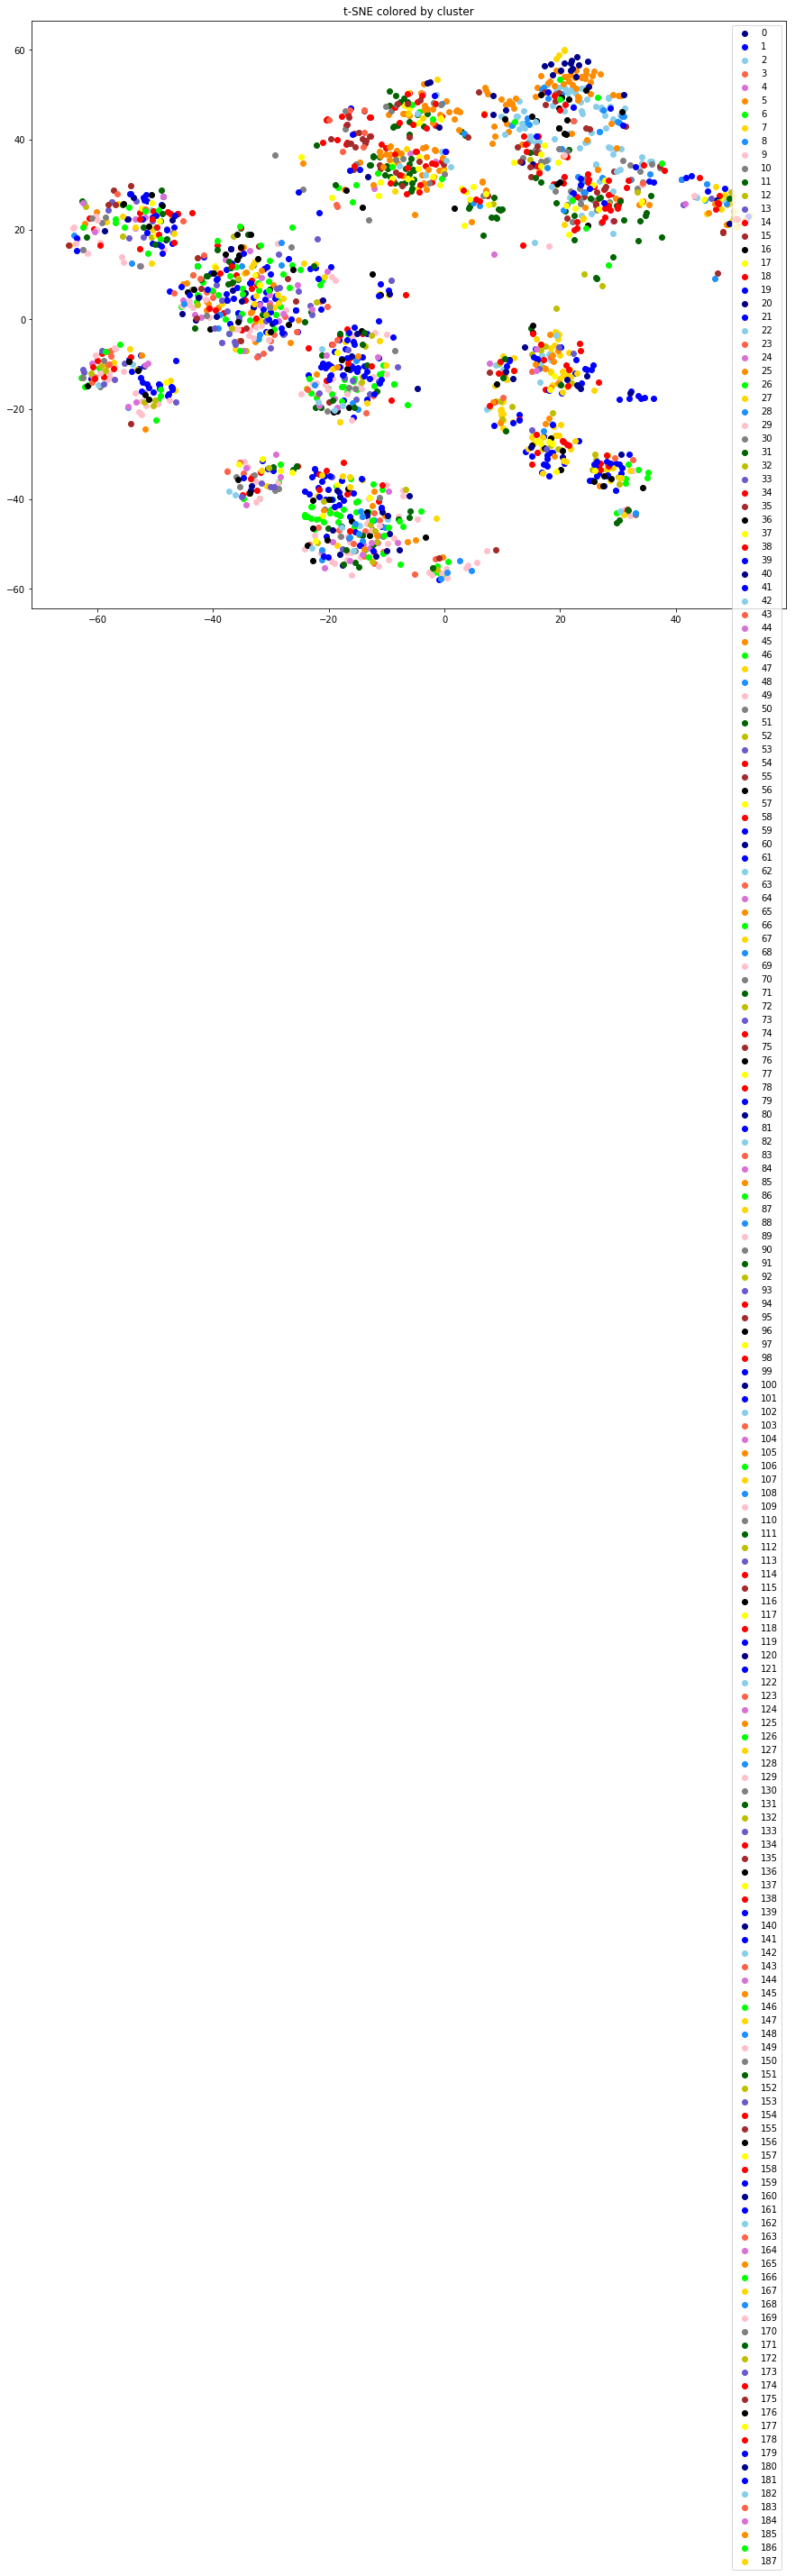

In [36]:
dtw_tsne = plot_df.merge(clusters_dtw, left_on='id', right_on='sku_key')

plot_by_factor(dtw_tsne, 'cluster', colors, True)

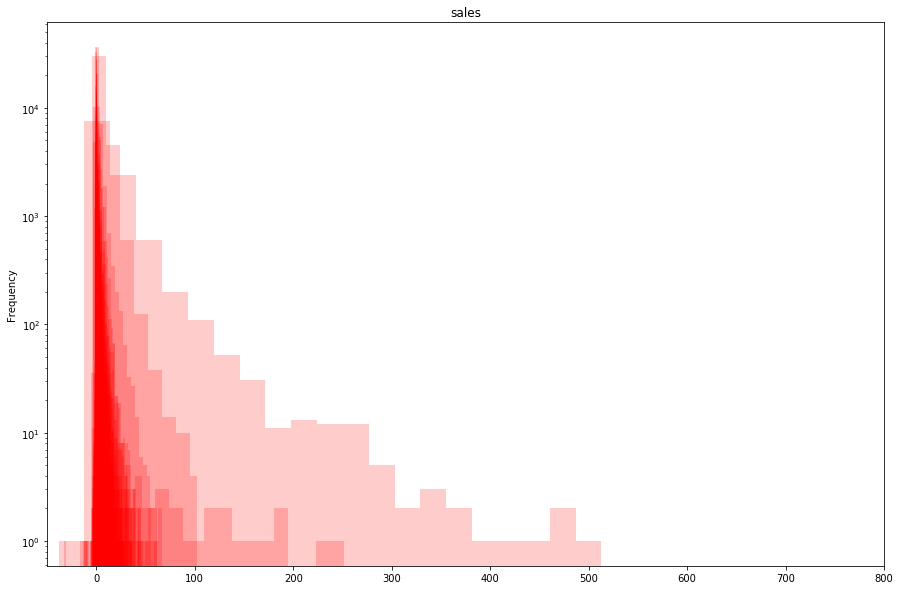

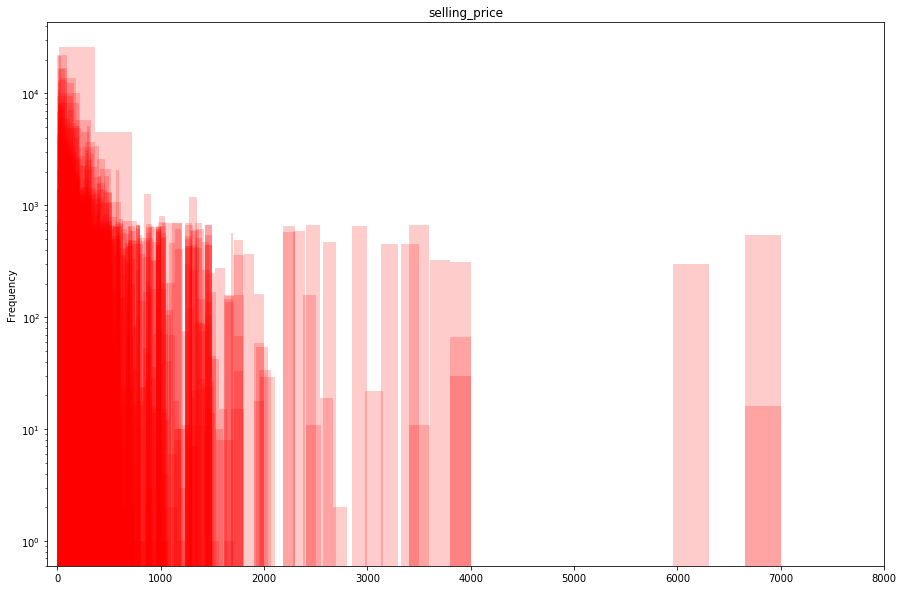

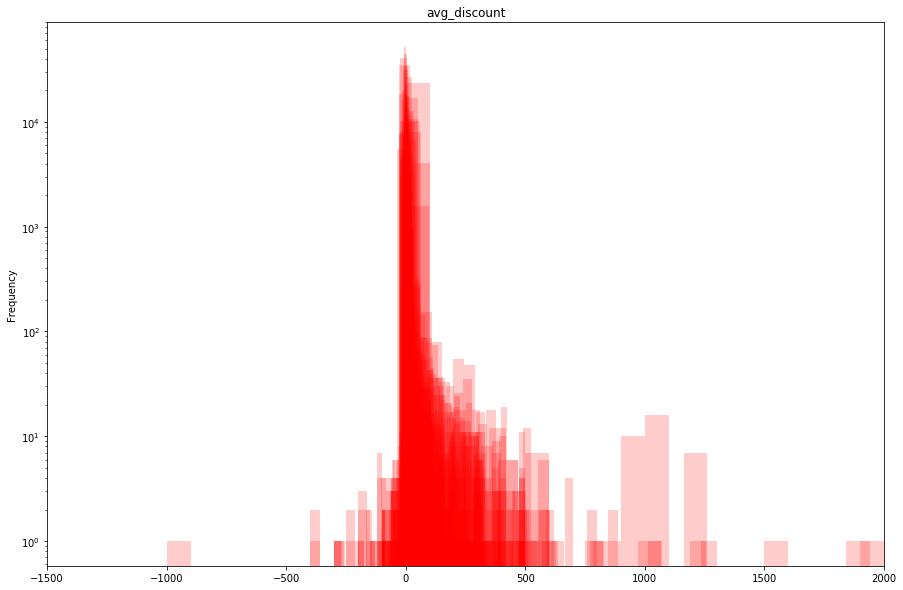

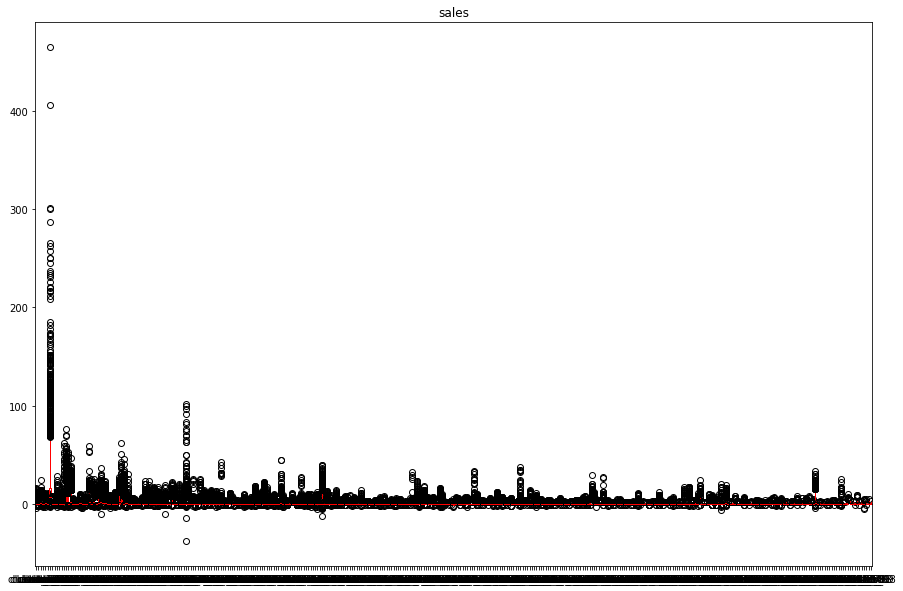

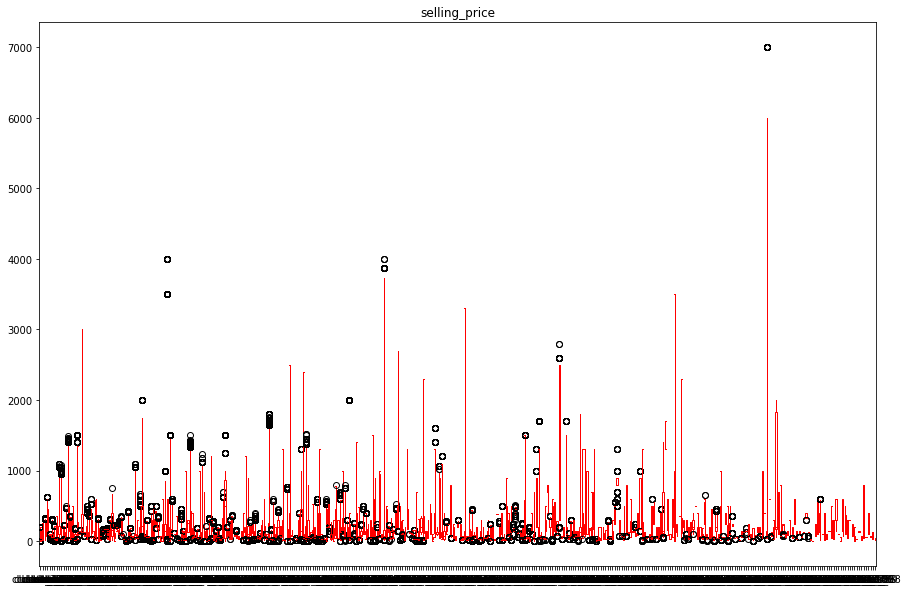

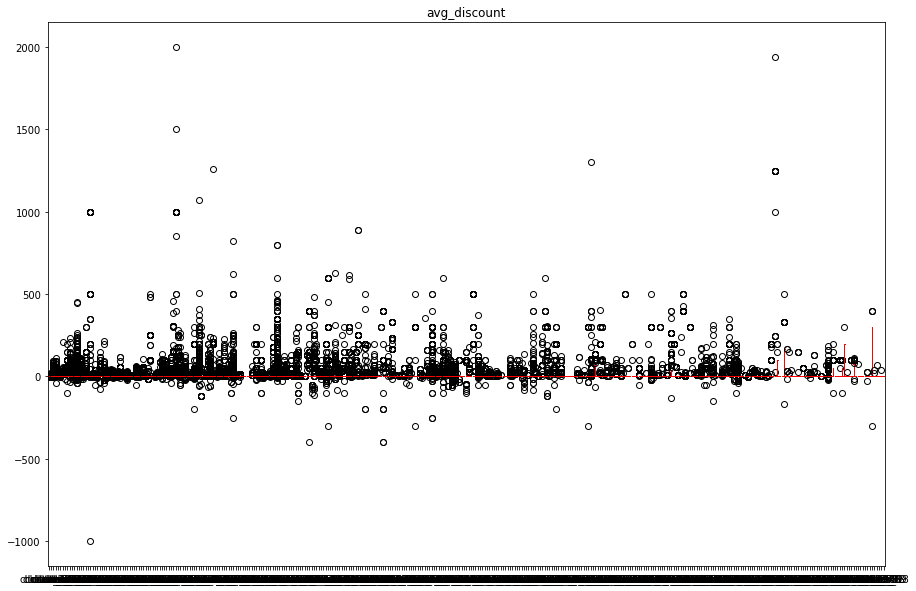

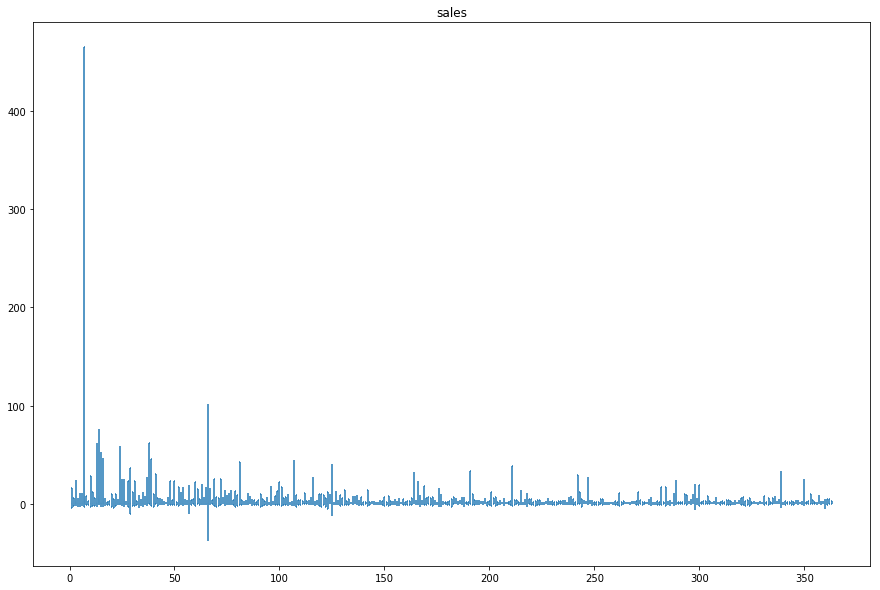

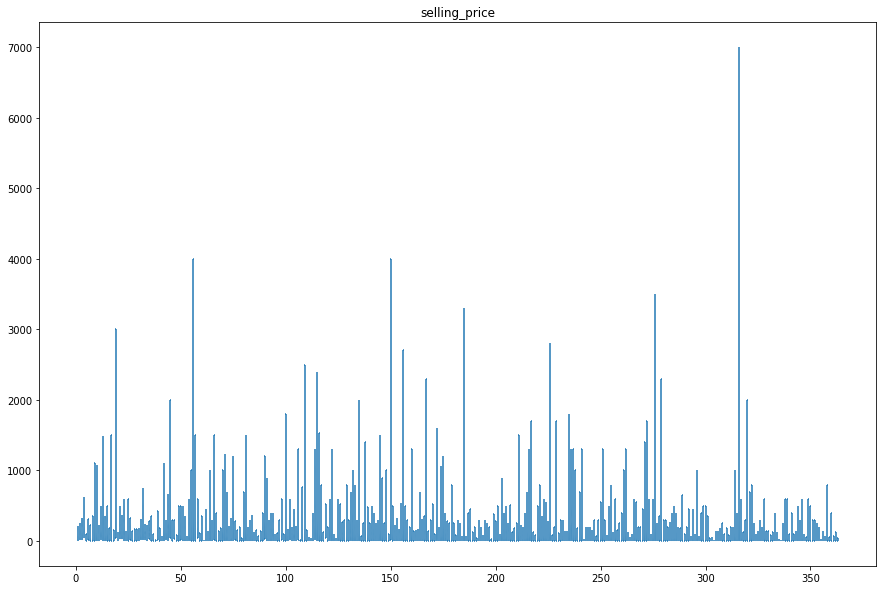

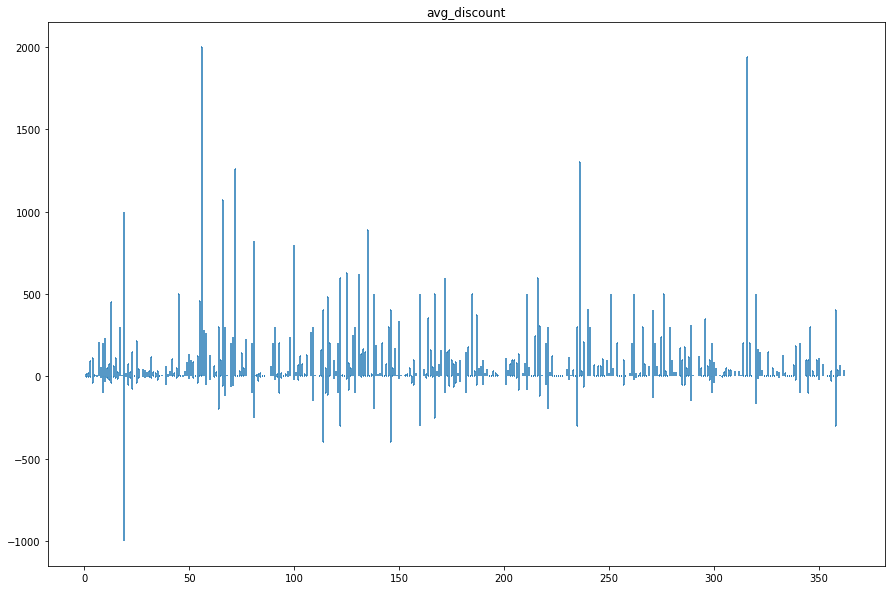



 sku_department


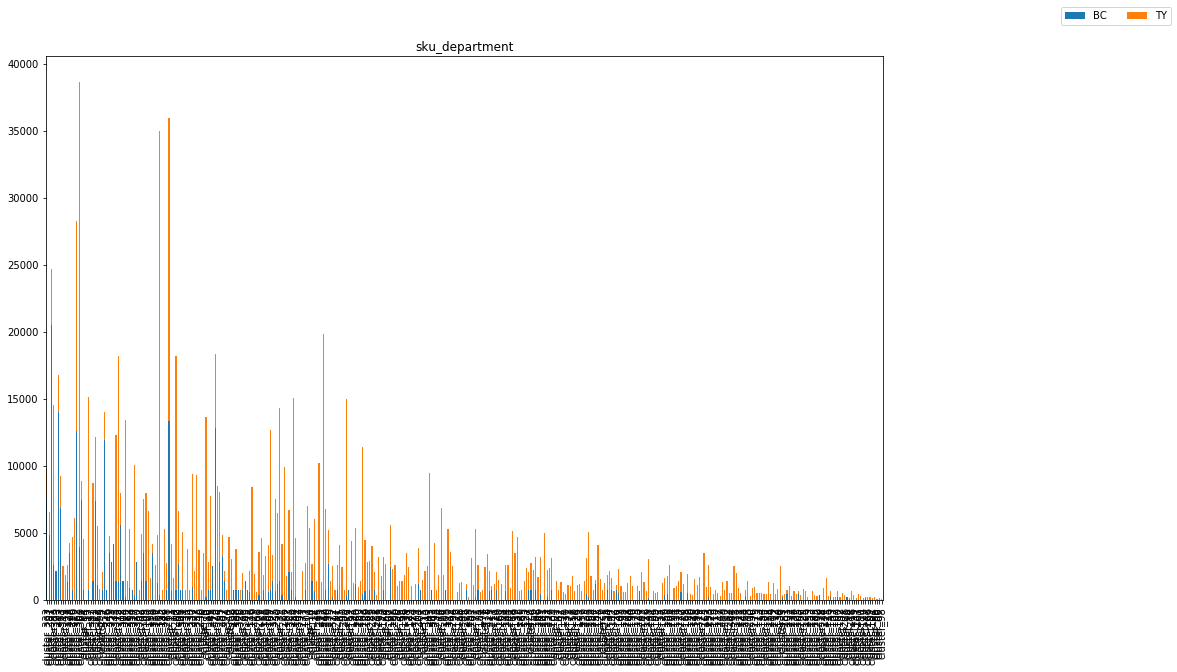



 sku_subdepartment


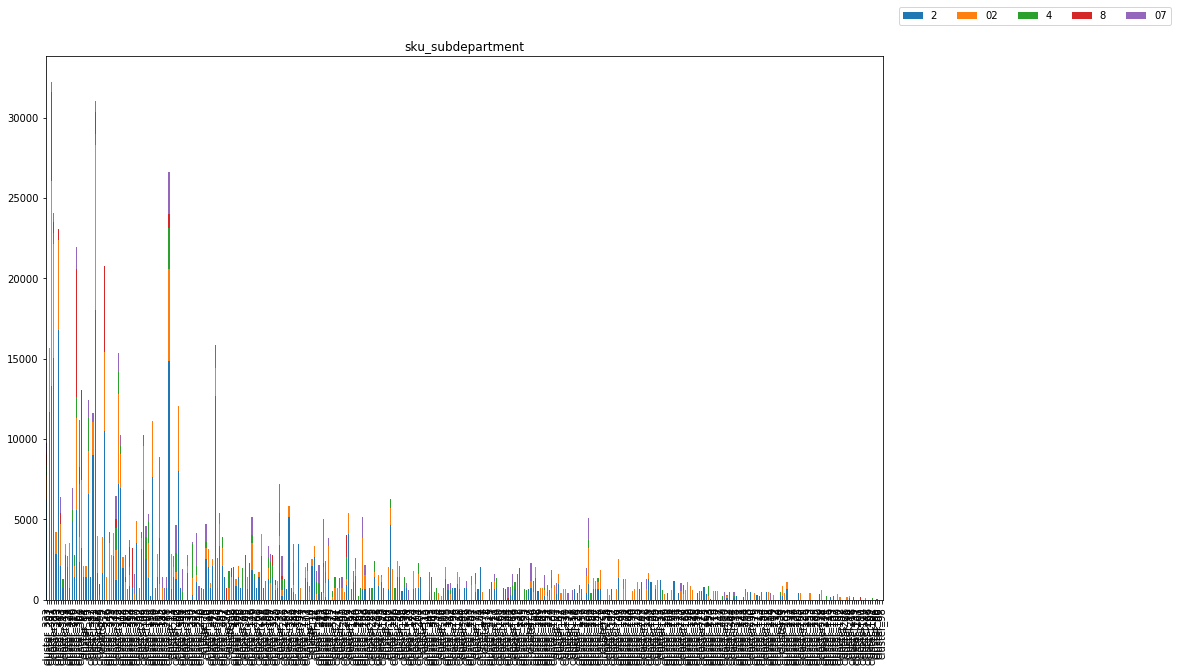



 sku_category


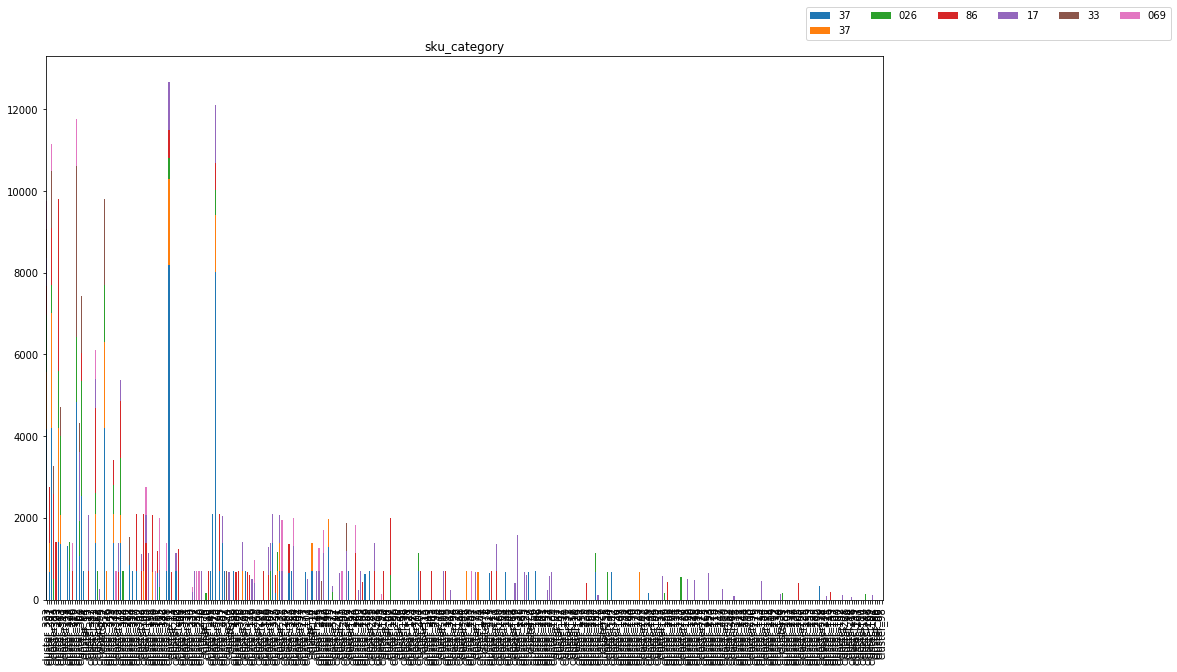



 sku_subcategory


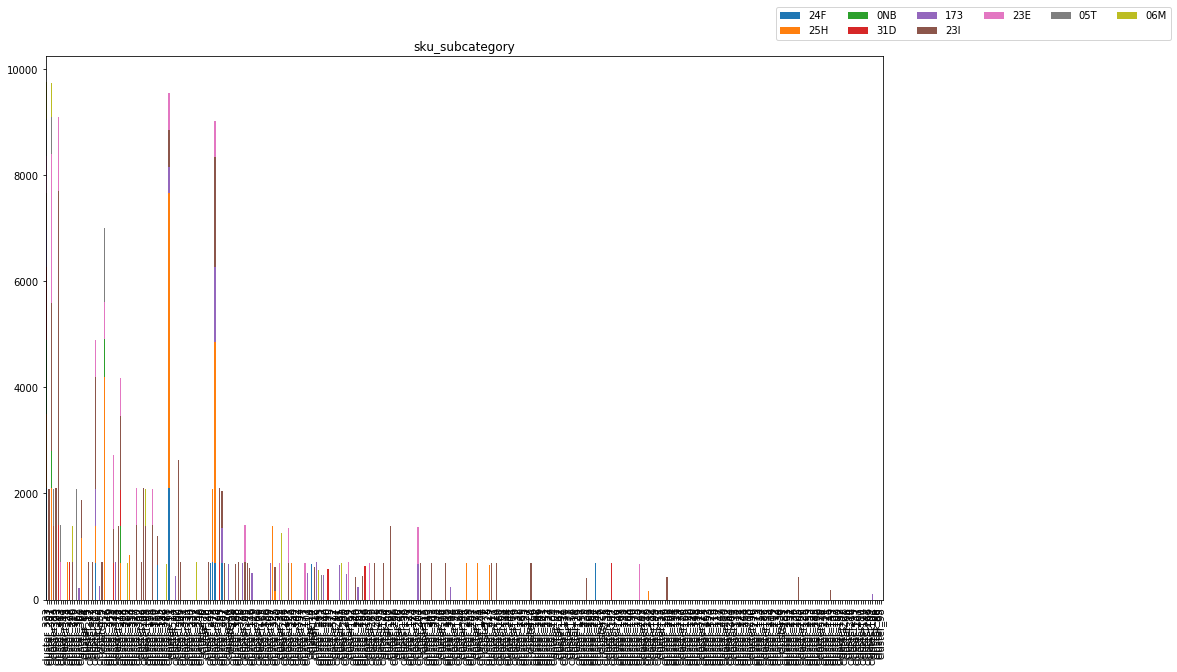

In [95]:
analyze_dtw.plot_cluster_continuous(df_dict, run_cont, colors, True)
analyze_dtw.plot_cluster_continuous_box(df_dict, run_cont, True)
analyze_dtw.plot_cluster_continuous_violin(df_dict, run_cont, True)
analyze_dtw.plot_cluster_categorical(df_dict, run_cats, True)

## Compare clusters

In [53]:
merge_df = plot_df[[0,1, 'sku_key']].merge(som_clus, on='sku_key').merge(tsne_clus, on='sku_key')

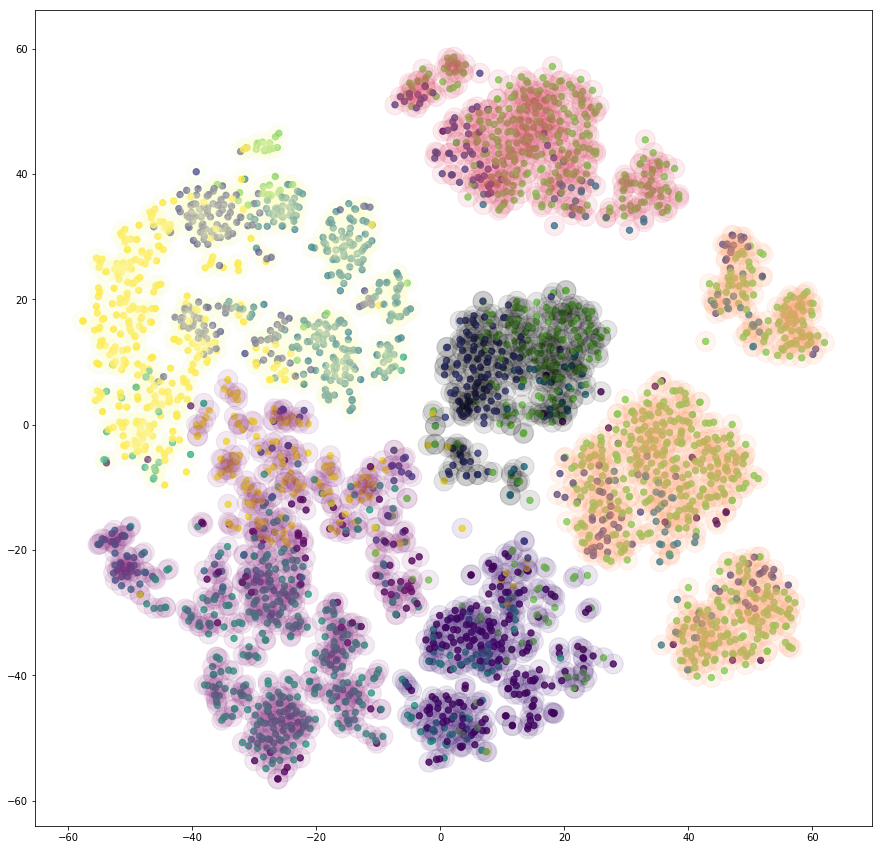

In [75]:
f, ax = plt.subplots(figsize=(15,15))
ax.scatter(merge_df[0], merge_df[1], c=merge_df['cluster_x'], alpha=0.8, s=40)
ax.scatter(merge_df[0], merge_df[1], c=merge_df['cluster_y'], alpha=0.1, cmap='magma_r', s=400)